# The stability of the global average on different window lengths
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from time import sleep

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
from typing import NamedTuple
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from functools import partial
import string

from numpy.typing import ArrayLike
from typing import List, Any, Callable, Union, Tuple, Optional

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'zecmip_stabilisation'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_zecmip
import utils
# import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import zec_calculation_functions
import signal_to_noise_calculations as sn_calc

# import drift_functions
import sn_plotting
import my_stats
# import signal_to_noise_calculations as sn_calc

# import sn_plotting_utils
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='dask.*')
warnings.filterwarnings("ignore", category=Warning)
# # Logging
logger = utils.get_notebook_logger()

Matplotlib created a temporary cache directory at /jobfs/123849798.gadi-pbs/matplotlib-ouqu9b_p because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'list_xarray'))
# from listXarray import listXarray
# import listXarray as lxr
from listXarray import listXarray, where, apply_ufunc, read_listxarray
# reload(lxr)
# from listXarray import array_function

In [3]:
# import listXarray
# reload(listXarray)
# from listXarray import listXarray

In [4]:
np.set_printoptions(precision=2, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [5]:
# client.close()

In [6]:
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1, n_workers=12)
client

- State start
- Found stale lock file and directory '/jobfs/123849798.gadi-pbs/dask-scratch-space/scheduler-0cex_4k1', purging
-   Scheduler at:     tcp://127.0.0.1:44465
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:42429'
-         Start Nanny at: 'tcp://127.0.0.1:46429'
-         Start Nanny at: 'tcp://127.0.0.1:38189'
-         Start Nanny at: 'tcp://127.0.0.1:42101'
-         Start Nanny at: 'tcp://127.0.0.1:39591'
-         Start Nanny at: 'tcp://127.0.0.1:37771'
-         Start Nanny at: 'tcp://127.0.0.1:37155'
-         Start Nanny at: 'tcp://127.0.0.1:38123'
-         Start Nanny at: 'tcp://127.0.0.1:34879'
-         Start Nanny at: 'tcp://127.0.0.1:37173'
-         Start Nanny at: 'tcp://127.0.0.1:34429'
-         Start Nanny at: 'tcp://127.0.0.1:38989'
- Register worker <WorkerState 'tcp://127.0.0.1:41495', name: 0, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44465,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41495,Total threads: 1
Dashboard: /proxy/37899/status,Memory: 0 B
Nanny: tcp://127.0.0.1:42429,


- Event loop was unresponsive in Nanny for 28.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 28.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 28.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 28.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 28.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 28.06s.  This is often caused by long

In [7]:
# One projeciton for when it is to be passed into a function. The other is when I am using it here.
# The passed function version also then used the same central longitude.
projection = ccrs.PlateCarree
projection_init = ccrs.PlateCarree()#central_longitude=np.mean(year_stable_model_average.lon.values))

In [8]:
units =  r'$^{\circ}C$'

In [9]:
NAMING_MAP = {'gl': 'Global',
 'nh': 'Northern Hemisphere',
 'sh': 'Southern Hemisphere',
 'tropics': 'Tropics',
 'land': 'Land',
 'ocean': 'Ocean',
 'mid_nh': 'Mid Latitudes NH',
 'mid_sh': 'Mid Latitudes SH',
 'arctic': 'Arctic',
 'antarctic': 'Antarctic',
 'global_warm': 'Warming Trends',
 'global_cool': 'Cooling Trends'}

In [10]:
# linestyles = ['--', '-'] * int(np.ceil(len(percent_stable_timeseries_data.model.values)/2))
linestyles = ['--', '-'] *5#int(np.ceil(len(percent_stable_timeseries_ds.model.values)/2))

linestyles

['--', '-', '--', '-', '--', '-', '--', '-', '--', '-']

In [11]:
ZEC_LINESTYLE_DICT = {
    'GISS-E2-1-G-CC': {'value': -0.09, 'color': '#add8e6', 'linestyle':  (0, (1, 1))},
     'CanESM5': {'value': -0.102, 'color': '#87ceeb', 'linestyle': '-'},
     'MIROC-ES2L': {'value': -0.109, 'color': '#6495ed', 'linestyle': ':'},
     'GFDL-ESM4': {'value': -0.205, 'color': '#4169e1', 'linestyle': '--'},
     'MPI-ESM1-2-LR': {'value': -0.27, 'color': '#1e90ff', 'linestyle': '-'},
     'CESM2': {'value': -0.31, 'color': '#0000cd', 'linestyle': '-'},
     'NorESM2-LM': {'value': -0.334,'color': '#00008b','linestyle': (0, (5, 1, 1, 1))},
     'ACCESS-ESM1-5': {'value': 0.011, 'color': [0.99, 0.7 , 0.48, 1.  ], 'linestyle': ':'},
     'UKESM1-0-LL': {'value': 0.289, 'color': [0.79, 0.11, 0.07, 1.  ]}}

In [12]:
# Sorting the models by their ZEC values
zec_values = list(map(lambda x: x['value'], list(ZEC_LINESTYLE_DICT.values())))
models = np.array(list(ZEC_LINESTYLE_DICT))
models_sorted = models[np.argsort(zec_values)]
models_sorted_name = np.sort(models_sorted)

models_sorted

array(['NorESM2-LM', 'CESM2', 'MPI-ESM1-2-LR', 'GFDL-ESM4', 'MIROC-ES2L',
       'CanESM5', 'GISS-E2-1-G-CC', 'ACCESS-ESM1-5', 'UKESM1-0-LL'],
      dtype='<U14')

In [13]:
sn_cmap, sn_levels = sn_plotting.generte_sn_cmap_and_levels(1/3)

[-3.   -2.67 -2.33 -2.   -1.67 -1.33 -1.   -0.67 -0.33]
[-0.33  0.    0.33  0.67  1.    1.33  1.67  2.    2.33  2.67  3.  ]


# Calculations

## Opening Data

In [14]:
chunks = {'lat':-1, 'lon':-1, 'time':-1, 'ensemble':-1}

In [15]:
a1_raw_data = (open_zecmip.extract_experiment_into_xrlist(
    '1000pgc', 'tas', chunks=chunks, logginglevel='ERROR')
                 .to_dataarray('tas')
                 .sort_by_refkey())

In [16]:
a1_raw_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1212, 'lat': 145, 'lon': 192})
              (Array: 128.72, Chunk: 128.72Mib) ({'ensemble': (1,), 'model': (1,), 'time': (1212,), 'lat': (145,), 'lon': (192,)})
CESM2          (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
              (Array: 379.69, Chunk: 126.56Mib) ({'ensemble': (1,), 'model': (1,), 'time': (600, 600, 600), 'lat': (192,), 'lon': (288,)})
CanESM5        (dataArray): ({'ensemble': 5, 'model': 1, 'time': 1200, 'lat': 64, 'lon': 128})
              (Array: 187.50, Chunk: 37.5Mib) ({'ensemble': (1, 1, 1, 1, 1), 'model': (1,), 'time': (1200,), 'lat': (64,), 'lon': (128,)})
GFDL-ESM4      (dataArray): ({'ensemble': 1, 'model': 1, 'time': 2400, 'lat': 180, 'lon': 288})
              (Array: 474.61, Chunk: 237.3Mib) ({'ensemble': (1,), 'model': (1,), 'time': (1200, 1200), 'lat': (180,), 'lon': (288,)})
GISS-E2-1-G-CC (dataArray): ({'ensembl

In [17]:
a1_raw_data.sel(model=['CESM2', 'NorESM2-LM'])

key_dim = model


Number of da/ds: 2
---------------
CESM2      (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
          (Array: 379.69, Chunk: 126.56Mib) ({'ensemble': (1,), 'model': (1,), 'time': (600, 600, 600), 'lat': (192,), 'lon': (288,)})
NorESM2-LM (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1200, 'lat': 96, 'lon': 144})
          (Array: 63.28, Chunk: 6.33Mib) ({'ensemble': (1,), 'model': (1,), 'time': (120, 120, 120, 120, 120, 120, 120, 120, 120, 120), 'lat': (96,), 'lon': (144,)})

In [18]:
a1_raw_data.isel(model=[1,2,4])

key_dim = model


Number of da/ds: 3
---------------
ACCESS-ESM1-5 (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
             (Array: 379.69, Chunk: 126.56Mib) ({'ensemble': (1,), 'model': (1,), 'time': (600, 600, 600), 'lat': (192,), 'lon': (288,)})
CESM2         (dataArray): ({'ensemble': 5, 'model': 1, 'time': 1200, 'lat': 64, 'lon': 128})
             (Array: 187.50, Chunk: 37.5Mib) ({'ensemble': (1, 1, 1, 1, 1), 'model': (1,), 'time': (1200,), 'lat': (64,), 'lon': (128,)})
CanESM5       (dataArray): ({'ensemble': 1, 'model': 1, 'time': 2160, 'lat': 90, 'lon': 144})
             (Array: 106.79, Chunk: 18.39Mib) ({'ensemble': (1,), 'model': (1,), 'time': (372, 600, 600, 588), 'lat': (90,), 'lon': (144,)})

In [19]:
pct_raw_data =  (open_zecmip.extract_experiment_into_xrlist('1pct', 'tas', chunks=chunks)
                   .to_dataarray('tas')
                   .sort_by_refkey())

In [20]:
# pi-Control (not ESM)
esmpi_raw_data = (open_zecmip.extract_experiment_into_xrlist('picontrol', 'tas', chunks=chunks, logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

- ACCESS-ESM1-5
-      r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316/*.nc
- CanESM5
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r1i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc
- UKESM1-0-LL
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc
- MPI-ESM1-2-LR
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/tas/gn/v20190710/*.nc
-      r2i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r2i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/piControl/r1i1p1f1/Amon/tas/gn/v2

In [21]:
### ESM-pi-Control
# esmpi_raw_data = (open_zecmip.extract_experiment_into_data('esm-piControl', 'tas', logginglevel='INFO') #esm-piControl'
#                     .to_dataarray('tas')
#                     # .isel(ensemble=0)
#                     # .squeeze('ensemble')
#                     .sort_by_refkey()
#                     .rename({'latitude':'lat', 'longitude': 'lon'}))

In [22]:
esmpi_raw_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 12000, 'lat': 145, 'lon': 192})
              (Array: 1274.41, Chunk: 637.21Mib) ({'model': (1,), 'time': (6000, 4800, 1200), 'lat': (145,), 'lon': (192,)})
CESM2          (dataArray): ({'model': 1, 'time': 14400, 'lat': 192, 'lon': 288})
              (Array: 3037.50, Chunk: 250.59Mib) ({'model': (1,), 'time': (1188, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1212), 'lat': (192,), 'lon': (288,)})
CanESM5        (dataArray): ({'model': 1, 'time': 16800, 'lat': 64, 'lon': 128})
              (Array: 525.00, Chunk: 65.69Mib) ({'model': (1,), 'time': (2102, 298, 1804, 596, 1506, 894, 1208, 1192, 910, 1490, 612, 1788, 314, 2086), 'lat': (64,), 'lon': (128,)})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 6000, 'lat': 180, 'lon': 288})
              (Array: 1186.52, Chunk: 237.3Mib) ({'model': (1,), 'time': (1200, 1200, 1200, 1200, 1200), 'lat': (180,), 'lon': (288,)})
GISS-E2-1-G-CC (d

In [23]:
# Making sure that the ensembles match. NOTE -  this can not be done
# with the piControl
a1_raw_data = a1_raw_data.cross_match_dim(pct_raw_data, 'ensemble')
pct_raw_data = pct_raw_data.cross_match_dim(a1_raw_data, 'ensemble')

In [24]:
# We are just looking at a single ensemble here.
a1_raw_data = a1_raw_data.isel(ensemble=0)
pct_raw_data = pct_raw_data.isel(ensemble=0)
esmpi_raw_data = esmpi_raw_data.isel(ensemble=0)

In [25]:
mask_ds = xr.open_dataset(os.path.join(constants.ZECMIP_LOCAL_DIR, 'landsea_mask.nc')) #_regridd_MPI_ESM
# mask_data = xr.open_dataset(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'landsea_mask_regridd_MPI_ESM.nc')); mask_data
mask_ds

<xarray.Dataset> Size: 150kB
Dimensions:  (lat: 96, lon: 192)
Coordinates:
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Data variables:
    mask     (lat, lon) int64 147kB ...
Attributes:
    Original model:  Made from data found at /g/data/oi10/replicas/CMIP6/C4MI...

In [26]:
import xesmf
regridded_file_list = []
for model in a1_raw_data.model:
    print(model)
    
    target_ds = a1_raw_data[model].isel(time=0).squeeze().drop(['ensemble', 'model', 'time'])
    
    regridder = xesmf.Regridder(mask_ds.mask , target_ds, method='nearest_s2d')
    regridded_file = regridder(mask_ds.mask)
    regridded_file = regridded_file.expand_dims(model=[model])
    regridded_file_list.append(regridded_file)

mask_data = listXarray(regridded_file_list, 'model')

ACCESS-ESM1-5


[gadi-cpu-spr-0498.gadi.nci.org.au:573549] shmem: mmap: an error occurred while determining whether or not /jobfs/123849798.gadi-pbs/ompi.gadi-cpu-spr-0498.13954/jf.0/1195966464/shared_mem_cuda_pool.gadi-cpu-spr-0498 could be created.
[gadi-cpu-spr-0498.gadi.nci.org.au:573549] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


CESM2
CanESM5
GFDL-ESM4
GISS-E2-1-G-CC
MIROC-ES2L
MPI-ESM1-2-LR
NorESM2-LM
UKESM1-0-LL


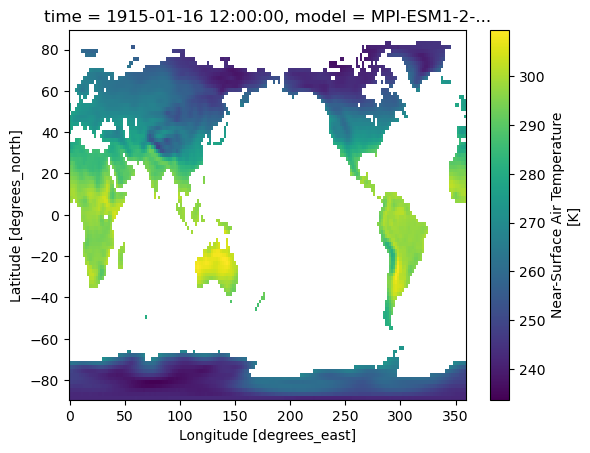

In [27]:
a1_raw_data[6].where(mask_data[6]).isel(time=0).plot()

In [28]:
# Convert to celcius
a1_raw_data = a1_raw_data - 273.15
pct_raw_data = pct_raw_data - 273.15
esmpi_raw_data = esmpi_raw_data - 273.15

In [29]:
# Can remove a lot of data, as I don't actually need this past the 70 year mark
# Data is montly so times by 12, a do 100 points just for saftery
pct_raw_data = pct_raw_data.isel(time=slice(0, 100 * 12))

In [30]:
# Yearly data transfomration - montly resolution is not needed
esmpi_data = esmpi_raw_data.chunk({'time':-1}).resample(time='Y').mean(dim='time').set_refkeys('model')
pct_resample_data = pct_raw_data.chunk({'time':-1}).resample(time='Y').mean(dim='time').set_refkeys('model')
a1_data = a1_raw_data.chunk({'time':-1}).resample(time='Y').mean(dim='time').set_refkeys('model')

# Can see this in the global mean time series. But this has errors after 1000
esmpi_data['CanESM5'] = esmpi_data['CanESM5'].isel(time=slice(None, 1000))

In [31]:
# Reduce time so that the smalles time densions matches. This is at 101 years
# a1_data = a1_data.isel(time=slice(None, 100))

## Anomaly Calculation

In [32]:
branch_point_mean_data = pct_resample_data(
    zec_calculation_functions.calculate_branch_average,
    a1_data, logginglevel='INFO')

- <function calculate_branch_average at 0x14651402f1c0> has been called
- ACCESS-ESM1-5
- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- CESM2
- ['CESM2'] - ['CESM2']
- branch_start_time=cftime.DatetimeNoLeap(68, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- CanESM5
- ['CanESM5'] - ['CanESM5']
- branch_start_time=cftime.DatetimeNoLeap(1911, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=61
- 

- GFDL-ESM4
- ['GFDL-ESM4'] - ['GFDL-ESM4']
- branch_start_time=cftime.DatetimeNoLeap(64, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=63
- 

- GISS-E2-1-G-CC
- ['GISS-E2-1-G-CC'] - ['GISS-E2-1-G-CC']
- branch_start_time=cftime.DatetimeNoLeap(1920, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=70
- 

- MIROC-ES2L
- ['MIROC-ES2L'] - ['MIROC-ES2L']
- branch_start_time=cftime.DatetimeGregorian(1913, 12, 31, 0, 0, 0, 0,

In [33]:
# # Base period calculation - 20 year average at branch poin
# branch_point_mean_data = listXarray([zec_calculation_functions.calculate_branch_average(
#     pct_data[model], a1_data[model], logginglevel='INFO') for model in pct_data.refkeys]).set_refkeys('model')

In [34]:
# Amomaly time series from the branch point (previosuly called 'experiment_zec_da_anom')
a1_anom_data = (a1_data - branch_point_mean_data)#.compute()

In [35]:
a1_anom_data = a1_anom_data.compute()

In [36]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_data = a1_anom_data.isel(time=slice(15, 35)).mean(dim='time')#.compute()
zec50_data = a1_anom_data.isel(time=slice(40, 60)).mean(dim='time')#.compute()
zec90_data = a1_anom_data.isel(time=slice(80, 100)).mean(dim='time')#.compute()
zec50_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144, 'lon': 192})

In [37]:
np.take(esmpi_data.dim('time', output='dict')['CanESM5'], [0,1,2,-3,-2,-1])

array([cftime.DatetimeNoLeap(5201, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(5202, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(5203, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(6198, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(6199, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(6200, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [38]:
# Reset to time zero
a1_anom_data = a1_anom_data(utils.reset_time_to_0_start, parallel_call=True)
pct_data = pct_resample_data(utils.reset_time_to_0_start, parallel_call=True)
esmpi_data = esmpi_data(utils.reset_time_to_0_start, parallel_call=True)

In [39]:
np.take(esmpi_data.dim('time', output='dict')['CanESM5'], [0,1,2,-3,-2,-1])

array([cftime.datetime(1, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(2, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(3, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(998, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(999, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(1000, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False)],
      dtype=object)

In [40]:
# These two can be computed as they are small (combined is around  100mb with each 
# model being around 7mb
a1_anom_data = a1_anom_data.compute()
pct_data = pct_data.compute()

In [41]:
# Each model is around 100mb. Parallel across this would be great. But would be 
# too much effort for now
esmpi_data = esmpi_data.compute()

## SN Calculation

In [42]:
# NOTE: This can only be done if all the time lengths are the same
# If they are different then PLEASE use listxarray
# Converted to xarray - all models now have matching coordinates

# a1_anom_data = a1_anom_data.drop('ensemble').concat('model').sortby('model').compute()
# esmpi_data = esmpi_data.drop('ensemble').concat('model').sortby('model').compute()
# a1_anom_detrend_data = a1_anom_detrend_data.concat('model').sortby('model').compute()
# pct_data = pct_data.concat('model').sortby('model')

In [43]:
a1_anom_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 101, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'time': 150, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'time': 100, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 200, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 180, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 248, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 185, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 330, 'lat': 144, 'lon': 192})

In [44]:
a1_anom_trend_data = a1_anom_data(my_stats.trend_fit, method='polynomial', order=4)
# a1_anom_trend_data=  my_stats_trend_fit(a1_anom_data, method='polynomial', order=4)
a1_anom_detrend_data= a1_anom_data - a1_anom_trend_data

In [45]:
# a1_anom_trend_data = my_stats.trend_fit(a1_anom_data, method='polynomial', order=4)
# a1_anom_detrend_data = a1_anom_data - a1_anom_trend_data

In [46]:
a1_anom_detrend_data = a1_anom_detrend_data.compute()

In [47]:
a1_anom_data.sel(lat=-38, method='nearest')

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 101, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'time': 150, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'time': 100, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 200, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 180, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 248, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 185, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 100, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 330, 'lon': 192})

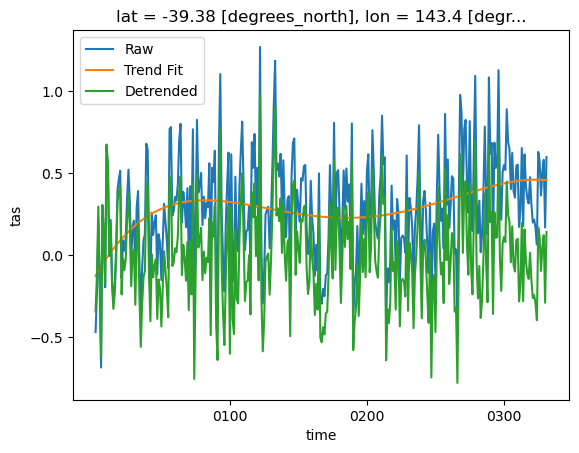

In [48]:
model = 'UKESM1-0-LL'#'CESM2'
a1_anom_data.sel(model=model).sel(lat=-39, lon=144, method='nearest').plot(label='Raw')
a1_anom_trend_data.sel(model=model).sel(lat=-39, lon=144, method='nearest').plot(label='Trend Fit')
a1_anom_detrend_data.sel(model=model).sel(lat=-39, lon=144, method='nearest').plot(label='Detrended')
plt.legend()

In [49]:
windows = np.arange(**constants.ZECMIP_MULTI_WINDOW_PARAMS)
windows

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [50]:
reload(sn_calc)

<module 'signal_to_noise_calculations' from '/home/563/ab2313/Documents/zecmip_stabilisation/src/signal_to_noise_calculations.py'>

In [51]:
chunk_sizes = {'time':-1, 'model':1, 'window':10, 'lat':-1, 'lon':-1}

In [52]:
A1_FILE_PATH = os.path.join(constants.ZECMIP_STABILISATION_DIR, 'sn_ratio_a1_p99_custom_windows_data')
PI_BOUNDS_FILE_PATH = os.path.join(constants.ZECMIP_STABILISATION_DIR, 'sn_ratio_bounds_p99_custom_windows_data')

In [53]:
if isinstance(a1_anom_data, (xr.Dataset, xr.DataArray)):
    A1_FILE_PATH = A1_FILE_PATH.replace('_data', '.zarr')
    PI_BOUNDS_FILE_PATH =  PI_BOUNDS_FILE_PATH.replace('_data', '.zarr')
else:
    A1_FILE_PATH = A1_FILE_PATH.replace('_data', '_xrlist')
    PI_BOUNDS_FILE_PATH =  PI_BOUNDS_FILE_PATH.replace('_data', '_xrlist')

In [54]:
A1_FILE_PATH, PI_BOUNDS_FILE_PATH

('/g/data/w40/ab2313/zecmip_stabilisation/sn_ratio_a1_p99_custom_windows_xrlist',
 '/g/data/w40/ab2313/zecmip_stabilisation/sn_ratio_bounds_p99_custom_windows_xrlist')

In [55]:
# constants.MODEL_WINDOW_INFORMATION

In [56]:
# %%time
# # BEST VERSION for A1
# # # ### Signal to noise Ration
# # # ### listXarray
# # # ### Unique windows for each model

# sn_ratio_a1_list = []
# for model in a1_anom_data.model:

#     model_windows = np.arange(10,constants.MODEL_WINDOW_INFORMATION[model]['max_window'])

#     print(model, model_windows)
#     n_workers = len(model_windows)
#     if n_workers > 45: n_workers = 45
#     client.cluster.scale(n_workers)#len(windows))
#     sleep(5) 
#     sn_ratio_a1_da_model =\
#         sn_calc.signal_to_noise_ratio_multi_window(
#         a1_anom_data.sel(model=model),
#         model_windows,
#         detrended_data=a1_anom_detrend_data.sel(model=model),
#         parallel=True,
#         start_align=False,
#         noise_type='rolling',
#         # min_periods='half',
#         logginglevel='ERROR'
#     )
#     sn_ratio_a1_da_model = sn_ratio_a1_da_model.drop('ensemble')
#     sn_ratio_a1_da_model.name = 'sn'
#     sn_ratio_a1_da_model = sn_ratio_a1_da_model.chunk(chunks=chunk_sizes)
#     sn_ratio_a1_list.append(sn_ratio_a1_da_model)
    
# sn_ratio_a1_data = listXarray(sn_ratio_a1_list, 'model')

In [57]:
# sn_ratio_a1_data.to_netcdf(A1_FILE_PATH)

In [58]:
# esmpi_chunks = {
#     'ACCESS-ESM1-5': {'time':-1, 'lat':int(145/5), 'lon':int(192/2) },
#     'CESM2': {'time':-1, 'lat':int(192/2), 'lon': int(288/2)},
#     'CanESM5': {'time':-1, 'lat':int(64/2), 'lon': int(128/2)},
#     'GFDL-ESM4': {'time':-1, 'lat':int(180/4), 'lon': int(288/2)},
#     'GISS-E2-1-G-CC': {'time':-1, 'lat':int(165/5), 'lon':int(144) },
#     'MIROC-ES2L': {'time':-1, 'lat':int(64/2), 'lon': int(128/2)},
#     'MPI-ESM1-2-LR': {'time':-1, 'lat':int(96/2), 'lon':int(192/2) },
#     'NorESM2-LM': {'time':-1, 'lat':int(96/2), 'lon': int(144/2)},
#     'UKESM1-0-LL': {'time':-1, 'lat':int(144/4), 'lon': int(192/2)},

# }

# esmpi_data = esmpi_data.chunk(esmpi_chunks)
# esmpi_data = esmpi_data.compute()#chunk(esmpi_chunks)

In [59]:
# %%time
# BEST VERSION for pi-Control
### Signal to noise Ration
### listXarray
### Unique windows for each model


##### NOTES ON RUNNING THIS
#### Can potentially be sclad to 15 for all BUT UKESSM
#### UKSEM: 5 workers iff no chunks (worker memory gets to 50gb). 
#### If UKESM is chunked (e.g. lat split in two, then the number of workers could also be 10)
#### without the memory getting too large. 
#### I have lots of cores though. Even dividing inton smaller chunks with more workers could improve this

# sn_ratio_bounds_list = []
# for model in esmpi_data.model:
#     model_windows = np.arange(10,constants.MODEL_WINDOW_INFORMATION[model]['max_window'])
#     if 'UKESM' in model:
#         client.cluster.scale(5)
#         sleep(5)
#     print(model, model_windows)
#     # n_workers = 20#len(model_windows)
#     # if n_workers > 45: n_workers = 45
#     # client.cluster.scale(n_workers)#len(windows))

#     sn_ratio_bounds_da = sn_calc.signal_to_noise_ratio_bounds_multi_window(
#         esmpi_data.sel(model=model),
#         model_windows, 
#         parallel=True, 
#         qlower=1, qupper=99,
#         logginglevel='INFO')
    
#     sn_ratio_bounds_list.append(sn_ratio_bounds_da)
    
# sn_ratio_bounds_data = listXarray(sn_ratio_bounds_list, 'model')

In [60]:
# print(PI_BOUNDS_FILE_PATH)
# sn_ratio_bounds_data.to_netcdf(PI_BOUNDS_FILE_PATH)

In [61]:
sn_ratio_a1_data = read_listxarray(A1_FILE_PATH).sn
sn_ratio_a1_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'window': 21, 'model': 1, 'time': 101, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'window': 37, 'model': 1, 'time': 150, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'window': 20, 'model': 1, 'time': 100, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'window': 54, 'model': 1, 'time': 200, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'window': 47, 'model': 1, 'time': 180, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'window': 70, 'model': 1, 'time': 248, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'window': 49, 'model': 1, 'time': 185, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'window': 20, 'model': 1, 'time': 100, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'window': 97, 'model': 1, 'time': 330, 'lat': 144, 'lon': 192})

In [62]:
sn_ratio_bounds_data = read_listxarray(PI_BOUNDS_FILE_PATH,
                                          logginglevel='ERROR')

In [63]:
sn_nan_locs_data = sn_ratio_a1_data.isel(lat=0, lon=0)(np.isnan)
sn_nan_locs_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'window': 21, 'model': 1, 'time': 101})
CESM2          (dataArray): ({'window': 37, 'model': 1, 'time': 150})
CanESM5        (dataArray): ({'window': 20, 'model': 1, 'time': 100})
GFDL-ESM4      (dataArray): ({'window': 54, 'model': 1, 'time': 200})
GISS-E2-1-G-CC (dataArray): ({'window': 47, 'model': 1, 'time': 180})
MIROC-ES2L     (dataArray): ({'window': 70, 'model': 1, 'time': 248})
MPI-ESM1-2-LR  (dataArray): ({'window': 49, 'model': 1, 'time': 185})
NorESM2-LM     (dataArray): ({'window': 20, 'model': 1, 'time': 100})
UKESM1-0-LL    (dataArray): ({'window': 97, 'model': 1, 'time': 330})

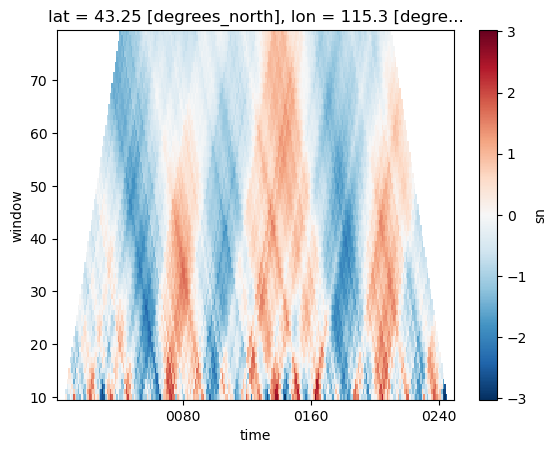

In [64]:
model='MIROC-ES2L'
lat_lon_dict = dict(lat=43, lon=115, method='nearest')
sn_ratio_a1_data[model].sel(**lat_lon_dict).plot(y='window')

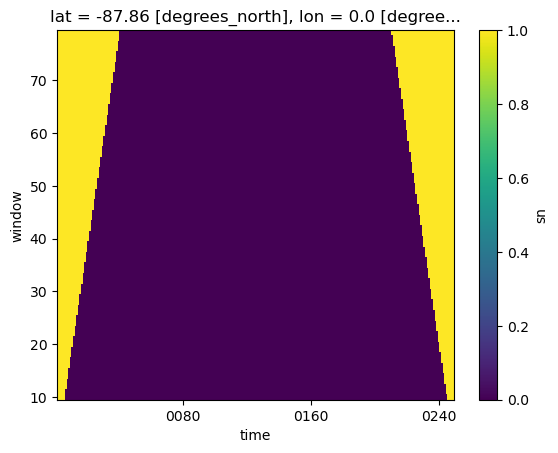

In [65]:
model='MIROC-ES2L'
# lat_lon_dict = dict(lat=43, lon=115, method='nearest')
sn_nan_locs_data[model].plot(y='window')

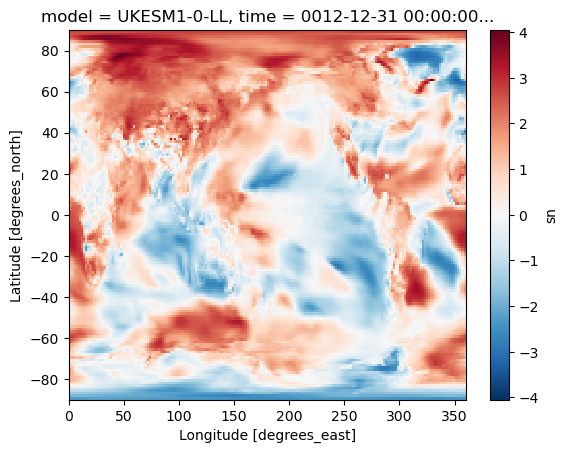

In [66]:
sn_ratio_a1_data[-1].isel(window=0, time=11).plot()

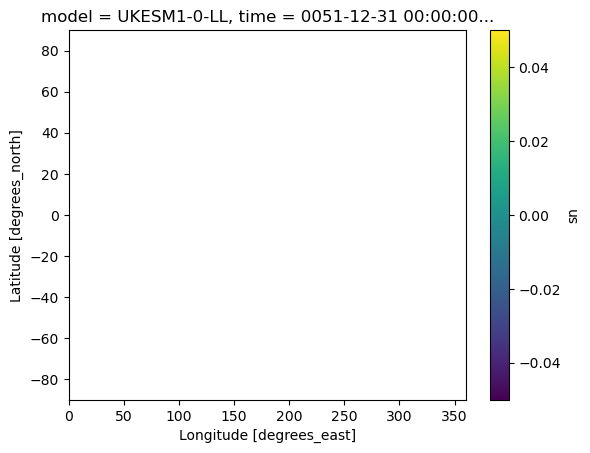

In [67]:
sn_ratio_a1_data[-1].isel(window=-1, time=50).plot()

In [68]:
# Open both the files. 
# This takes ages to run - so files have been saved
# sn_ratio_a1_data = xr.open_dataarray(A1_FILE_PATH, engine='zarr', chunks=chunk_sizes)
# sn_ratio_bounds_data = xr.open_dataset(PI_BOUNDS_FILE_PATH,engine='zarr')

In [69]:
sn_ratio_bounds_data.window #.values

{'ACCESS-ESM1-5': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30]),
 'CESM2': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46]),
 'CanESM5': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29]),
 'GFDL-ESM4': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
        61, 62, 63]),
 'GISS-E2-1-G-CC': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]),
 'MIROC-ES2L': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
    

In [70]:
sn_ratio_a1_data = sn_ratio_a1_data.drop('ensemble')
sn_ratio_bounds_data = sn_ratio_bounds_data.drop('ensemble')

In [71]:
# The S/N ratio that is unstable - e.g. the A1 S/N where the pi-control is unstable
unstable_sn_data = sn_ratio_a1_data.where(
    (sn_ratio_a1_data>sn_ratio_bounds_data.upper_bound) | # Greater than upper-bounds
    (sn_ratio_a1_data<sn_ratio_bounds_data.lower_bound))# Less than lower bound

unstable_sn_data = unstable_sn_data.transpose(*['window', 'time', 'model', 'lat', 'lon'])

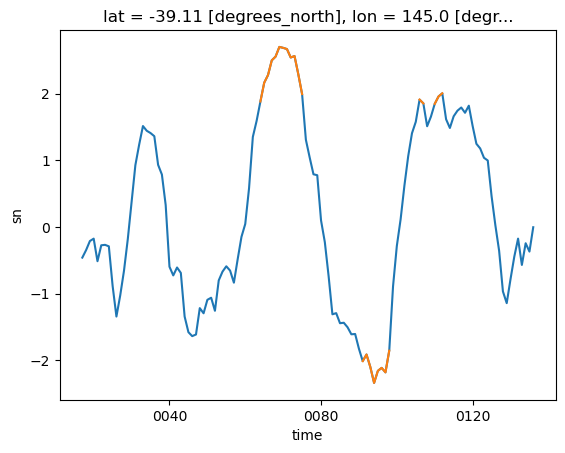

In [72]:
sn_ratio_a1_data[1].sel(window=31).sel(lat=-39, lon=145, method='nearest').plot()
unstable_sn_data[1].sel(window=31).sel(lat=-39, lon=145, method='nearest').plot()

In [73]:
unstable_sn_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'window': 21, 'time': 101, 'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'window': 37, 'time': 150, 'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'window': 20, 'time': 100, 'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'window': 54, 'time': 200, 'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'window': 47, 'time': 180, 'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'window': 70, 'time': 248, 'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'window': 49, 'time': 185, 'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'window': 20, 'time': 100, 'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'window': 97, 'time': 330, 'model': 1, 'lat': 144, 'lon': 192})

# Stable Year Detection
This method use when all windows lengths become stable. The method then finds which window lengths are the windows that are unstable, and get the last unstable point in these windows

In [74]:
dim_order = ['time', 'window' , 'model', 'lat', 'lon']
dim_order

['time', 'window', 'model', 'lat', 'lon']

In [75]:
chunks = {
    'ACCESS-ESM1-5': {'time':-1, 'window':-1, 'lat':int(145/4), 'lon':int(192/2)},   # too big
    'CESM2': {'time':-1, 'window':-1, 'lat':int(145/4), 'lon':int(192/4)},
    'CanESM5': {'time':-1, 'window':-1, 'lat':int(64/4), 'lon':int(128/4)},
    'GFDL-ESM4': {'time':-1, 'window':-1, 'lat':int(180/3), 'lon':int(144/4)},
    'GISS-E2-1-G-CC': {'time':-1, 'window':-1, 'lat':int(90/2), 'lon':int(192/4)},
    'MIROC-ES2L': {'time':-1, 'window':-1, 'lat':int(64/2), 'lon':int(128/2)},
    'MPI-ESM1-2-LR': {'time':-1, 'window':-1, 'lat':int(96/2), 'lon':int(192/2)},
    'NorESM2-LM': {'time':-1, 'window':-1, 'lat':int(96/2), 'lon':int(144/4)},
    'UKESM1-0-LL': {'time':-1, 'window':-1, 'lat':int(144/2), 'lon':int(192/3)},
}

In [76]:
unstable_sn_data = unstable_sn_data.transpose(*dim_order).chunk(chunks)
#{'time':-1, 'window':-1, 'lat':int(150/2), 'lon':int(200/2)}))
unstable_sn_data = unstable_sn_data.persist()

In [77]:
# client.cluster.scale(25)
# sleep(4)

In [78]:
unstable_sn_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'time': 101, 'window': 21, 'model': 1, 'lat': 145, 'lon': 192})
              (Array: 450.51, Chunk: 55.92Mib) ({'time': (101,), 'window': (21,), 'model': (1,), 'lat': (36, 36, 36, 36, 1), 'lon': (96, 96)})
CESM2          (dataArray): ({'time': 150, 'window': 37, 'model': 1, 'lat': 192, 'lon': 288})
              (Array: 2341.41, Chunk: 73.17Mib) ({'time': (150,), 'window': (37,), 'model': (1,), 'lat': (36, 36, 36, 36, 36, 12), 'lon': (48, 48, 48, 48, 48, 48)})
CanESM5        (dataArray): ({'time': 100, 'window': 20, 'model': 1, 'lat': 64, 'lon': 128})
              (Array: 125.00, Chunk: 7.81Mib) ({'time': (100,), 'window': (20,), 'model': (1,), 'lat': (16, 16, 16, 16), 'lon': (32, 32, 32, 32)})
GFDL-ESM4      (dataArray): ({'time': 200, 'window': 54, 'model': 1, 'lat': 180, 'lon': 288})
              (Array: 4271.48, Chunk: 177.98Mib) ({'time': (200,), 'window': (54,), 'model': (1,), 'lat': (60, 60, 60), 'lon': (36, 36,

In [79]:
dim_order

['time', 'window', 'model', 'lat', 'lon']

In [ ]:
### The year stable and unstalbe not must be done seperatly per model, 
### this is becuase the windows is now different depending on the model.
year_stable_and_unstable_model_list = []
for model in unstable_sn_data.model:
    unstable_sn_da =  unstable_sn_data.sel(model=model)

    model_windows = unstable_sn_da.window.values
    max_val = constants.MODEL_WINDOW_INFORMATION[model]['time_length']- 11
    print(model, max_val ,model_windows)
    
    year_stable_and_unstable_model_ds = xr.apply_ufunc(
        partial(sn_calc.calcuate_year_stable_and_unstable, windows=model_windows),
        unstable_sn_da,#.transpose(*dim_order),
        input_core_dims=[['time', 'window']],
        output_core_dims=[['stability_index']],
        dask_gufunc_kwargs={'output_sizes': {'stability_index': 7}},
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float64],
        kwargs={'max_val': max_val, 'logginglevel':'ERROR'}
    ).compute()
    year_stable_and_unstable_model_ds=year_stable_and_unstable_model_ds.assign_coords(
        stability_index=[1, 2, 3, 4, 5, 6, 7])
    
    year_stable_and_unstable_model_ds.attrs['Stability index'] ='Odd values mean stable, even mean unstable'

    year_stable_and_unstable_model_list.append(year_stable_and_unstable_model_ds)

year_stable_unstable_data = listXarray(year_stable_and_unstable_model_list, 'model')

ACCESS-ESM1-5 90 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]


In [ ]:
year_stable_unstable_data

In [ ]:
# %%time
# year_stable_unstable_data_raw = apply_ufunc(
#     sn_calc.calcuate_year_stable_and_unstable,
#     unstable_sn_data,
#     # (unstable_sn_data.transpose(*dim_order)
#      # .sel(lat=slice(-15,-5), lon=slice(150, 160))
#     # ),
#     input_core_dims=[['time', 'window']],
#     output_core_dims=[['stability_index']],
#     dask_gufunc_kwargs={'output_sizes': {'stability_index': 9}},
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float64],
#     kwargs = {'windows': windows, 'number_attempts':9, 'logginglevel':'ERROR'}
# ).compute()


In [ ]:
# client.cluster.scale(12)
# sleep(4)

In [ ]:
# td = xr.apply_ufunc(
#     sn_calc.calcuate_year_stable_and_unstable,
#     (unstable_sn_data[model]
#      .transpose(*dim_order)
#      .chunk({'time':-1, 'window':-1, 'lat':int(150/2), 'lon':int(192/2)}).sel(lat=slice(-15,-5), lon=slice(150, 160))
#      # .isel(lat=slice(0,30), lon=slice(0,100))
#     ),
#     input_core_dims=[['time', 'window']],
#     output_core_dims=[['stability_index']],
#     dask_gufunc_kwargs={'output_sizes': {'stability_index': 9}},
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float64],
#     kwargs = {'windows': windows, 'number_attempts':9, 'logginglevel':'ERROR'}
# ).compute()
# # td = td.compute()

In [ ]:
# Assigning coords and adding attrs
# There are currently no methods for this.

# year_stable_unstable_list = []
# for model, ds in year_stable_unstable_data_raw:
#     ds=ds.assign_coords(stability_index=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    
#     ds.attrs['Stability index'] ='Odd values mean stable, even mean unstable'
#     year_stable_unstable_list.append(ds)

# year_stable_unstable_data = listXarray(year_stable_unstable_list,'model')

In [ ]:
# lat_lon_dict = dict(lat=75, lon=75, method='nearest')
# lat_lon_dict = dict(lat=85, lon=75, method='nearest')
# lat_lon_dict = dict(lat=89, lon=76 , method='nearest')
# lat_lon_dict = dict(lat=80, lon=140 , method='nearest')

In [ ]:
year_stable_unstable_data

In [ ]:

model='MIROC-ES2L'
lat_lon_dict = dict(lat=43, lon=115, method='nearest')
year_stable_unstable_data[model].sel(**lat_lon_dict)

In [ ]:
unstable_sn_data[model].sel(**lat_lon_dict).plot(y='window')

In [ ]:
a1_anom_data[model].sel(**lat_lon_dict).plot()

In [ ]:
reload(sn_plotting)

In [ ]:
model='MIROC-ES2L'
lat_lon_dict = dict(lat=43, lon=115, method='nearest')
fig, ax1, ax2 = sn_plotting.plot_stabilization(lat_lon_dict, model, a1_anom_data, unstable_sn_data,
                                               year_stable_unstable_data)

In [ ]:
a1_anom_data[model].sel(**lat_lon_dict)

In [ ]:
sn_ratio_a1_data[model].sel(**lat_lon_dict)

In [ ]:
sn_ratio_a1_data[2].sel(**lat_lon_dict)

In [ ]:
fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
model='NorESM2-LM'
lat_lon_dict = dict(lat=60, lon=317.5, method='nearest')
sn_ratio_a1_data[model].sel(**lat_lon_dict).plot(ax=ax, y='window')
# a1_anom_data[model].sel(**lat_lon_dict).plot(ax=ax2)

In [ ]:
model='NorESM2-LM'
lat_lon_dict = dict(lat=60, lon=317.5, method='nearest')
fig, ax1, ax2 = sn_plotting.plot_stabilization(lat_lon_dict, model, a1_anom_data, unstable_sn_data,
                                               year_stable_unstable_data)

In [ ]:
lat_lon_dict = dict(lat=58, lon=334, method='nearest')
model = 'CESM2'
fig, ax1, ax2 = sn_plotting.plot_stabilization(lat_lon_dict, model, a1_anom_data, 
                                               sn_ratio_a1_data, year_stable_unstable_data)

In [ ]:
lat_lon_dict = dict(lat=58, lon=334, method='nearest')
model = 'CESM2'
fig, ax1, ax2 = sn_plotting.plot_stabilization(lat_lon_dict, model, a1_anom_data, unstable_sn_data, year_stable_unstable_data)

In [ ]:
lat_lon_dict = dict(lat=80, lon=140 , method='nearest')
model = 'ACCESS-ESM1-5'
year_stable_unstable_data[model].sel(**lat_lon_dict).values

In [ ]:
unstable_sn_data

In [ ]:
unstable_sn_data[model].sel(**lat_lon_dict).plot(y='window')

In [ ]:
lat_lon_dict = dict(lat=80, lon=140 , method='nearest')
model = 'ACCESS-ESM1-5'
fig, ax1, ax2 = sn_plotting.plot_stabilization(lat_lon_dict, model, a1_anom_data, unstable_sn_data, year_stable_unstable_data)

In [ ]:
# Example usage:
lat_lon_dict = dict(lat=89, lon=76 , method='nearest')
model = 'ACCESS-ESM1-5'
fig, ax1, ax2 = sn_plotting.plot_stabilization(lat_lon_dict, model, a1_anom_data, unstable_sn_data, year_stable_unstable_data)

In [ ]:
# Example usage:
lat_lon_dict = dict(lat=85, lon=75, method='nearest')
model = 'ACCESS-ESM1-5'
fig, ax1, ax2 = sn_plotting.plot_stabilization(lat_lon_dict, model, a1_anom_data, unstable_sn_data, year_stable_unstable_data)

# Stable Anomalies

In [ ]:
year_stable_data = year_stable_unstable_data.sel(stability_index=1)#total_stable_year_data#year_stable_data_original

In [ ]:
def get_anomalies_at_stabilisations(years, values, expected_length=6, logginglevel='ERROR'):
    """
    Calculate the mean of value selections during stabilization periods based on provided years.
    
    Parameters:
    years (array-like): An array of years with stabilization periods.
    values (array-like): An array of values corresponding to each year.
    expected_length (int): The expected length of the output list. If the calculated list 
                           is shorter, it will be padded with NaN values. Default is 6.
                           
    Returns:
    numpy.ndarray: An array of mean values for each stabilization period. If the number of 
                   stabilization periods is less than expected_length, the array is padded 
                   with NaN values.
    """
    utils.change_logginglevel(logginglevel)
    # Remove all NaN values from the years array
    years = years[np.isfinite(years)]
    
    logger.info(years)

    value_mean_list = []
    
    # Iterate through each year
    for i in range(len(years)):

        # Check if the index corresponds to a stabilization year (0, 2, 4, ...)
        if 1 - i % 2:  # True for even indices
            
            # Define the start year of the stabilization period
            start = years[i]
            
            # Define the end year, which is either 20 years after the start or the beginning of the next period
            if i < len(years) - 1:
                end = start + np.nanmin([20, years[i+1] - start])
            else:
                end = start + 20

            start = int(start)
            end = int(end)

            logger.debug(f'{start=}, {end=}')
    
            # Select the values corresponding to the stabilization period
            value_selection = values[start:end]
            
            # Calculate the mean of the selected values and add it to the list
            value_mean = np.mean(value_selection)
            value_mean_list.append(value_mean)
        else:
            pass

    # If the number of calculated means is less than expected_length, pad the list with NaN values
    if len(value_mean_list) < expected_length:
        value_mean_list = np.concatenate([value_mean_list, np.tile(np.nan, expected_length - len(value_mean_list))])
    
    return value_mean_list


In [ ]:
expected_length = len(year_stable_unstable_data.stability_index[::2])
expected_length

In [ ]:
# Stabilises year 23 and becomes unstable again year 34=> start=23, end =34
# Restabilises again at year 50 => start 50, end 70
# get_anomalies_at_stabilisations(np.array([23, 34, 50 ]), np.tile(1, 70))#np.array([1]*23, []))
get_anomalies_at_stabilisations(np.array([0, 10, 30]), np.array([1]*10 + [100] * 20 + [20]), expected_length=expected_length, 
                               logginglevel='DEBUG')

In [ ]:
a1_anom_data

In [ ]:
year_stable_unstable_data

In [ ]:
stable_point_anoms_raw = apply_ufunc(
    get_anomalies_at_stabilisations,
    year_stable_unstable_data,
    a1_anom_data.isel(time=slice(0, 70)),
    input_core_dims=[['stability_index'], ['time']],
    output_core_dims=[['stabil_num']],
    vectorize=True,
    dask_gufunc_kwargs={'output_sizes':{'stabil_num': expected_length}},
    kwargs = {'expected_length':expected_length, 'logginglevel':'ERROR'}
)
# test_anoms = test_anoms.assign_coords(stabil_num=np.arange(expected_length))

In [ ]:
stable_point_anoms_list = []
for model, ds in stable_point_anoms_raw:
    ds=ds.assign_coords(stabil_num=np.arange(1, expected_length+1))
    
    ds.attrs['stabil_num'] ='The average at each stabilisation period'
    stable_point_anoms_list.append(ds)
                                   
stable_point_anoms = listXarray(stable_point_anoms_list, 'model')

In [ ]:
final_temp_data = stable_point_anoms.max(dim='stabil_num')

In [ ]:
def plot_stippled_data(sig, ax, sig_size:float=2, alpha=1):

    # The result will be scattered, so we need a meshgrid.
    X,Y = np.meshgrid(sig.lon, sig.lat)
    size = np.nan_to_num(sig.values, 0)

    ax.scatter(X,Y, s=size * sig_size, color='k', alpha=alpha)

In [ ]:
final_stabilisation_data = year_stable_unstable_data.isel(stability_index=[0, 2, 4,6,8]).max(dim='stability_index')

In [ ]:
stable_after_zec50_data = where(final_stabilisation_data>45, 0, 1)

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines()
plot_stippled_data(stable_after_zec50_data[2], ax)

In [ ]:
imodel = 8
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
(final_temp_data[imodel]-zec50_data[imodel]).squeeze().plot.contourf(ax=ax, robust=True)
ax.coastlines()

plot_stippled_data(stable_after_zec50_data[imodel], ax, alpha=0.6)

In [ ]:
# Get the 20-year average tempeature anomaly at stabilisation.
stable_anom_da = apply_ufunc( #xr.
    sn_calc.get_average_after_stable_year,
    a1_anom_data,
    year_stable_data,
    input_core_dims=[['time'],[]],
    output_core_dims=[[]],
    output_dtypes=[np.float],
    vectorize=True
)

In [ ]:
stable_anom_da

# Region Percent Stable Time series

In [ ]:
class Region(NamedTuple):
    name: str
    slice: tuple

class regionLatLonTuples(Enum):
    GLOBAL = Region('gl', slice(None, None))
    LAND = Region('land', slice(None, None))
    OCEAN = Region('ocean', slice(None, None))
    NH = Region('nh', slice(0, None))
    SH = Region('sh', slice(None, 0))
    TROPICS = Region('tropics', slice(-23, 23))
    MID_LAT_SH = Region('mid_sh', slice(-66, -23))
    MID_LAT_NH = Region('mid_nh', slice(23, 66))
    ARCTIC = Region('arctic', slice(66, None))
    ANTARCTIC = Region('antarctic', slice(None, -66))


NAMING_MAP = {
    'global': 'Global',
    'nh': 'Northern Hemisphere',
    'sh': 'Southern Hemisphere',
    'tropics': 'Tropics',
    'land': 'Land',
    'ocean': 'Ocean',
    'mid_nh': 'Mid Latitudes NH',
    'mid_sh': 'Mid Latitudes SH',
    'arctic': 'Arctic',
    'antarctic': 'Antarctic'}

In [ ]:
def fraction_comparison(ds_num, ds_denom, weights):
    """
    Calculate the percentage by comparing two datasets.

    Parameters:
        ds_num (xarray.Dataset): Numerator dataset.
        ds_denom (xarray.Dataset): Denominator dataset.
        weights (xarray.DataArray): Weights for the calculation.

    Returns:
        xarray.DataArray: Dataset containing the percentage.
    """
    # Calculate the sum of the numerator dataset weighted by weights
    ds_num_sum = ds_num.weighted(weights).sum(dim=['lat', 'lon'])

    # Calculate the sum of the denominator dataset weighted by weights
    ds_denom_sum = ds_denom.weighted(weights).sum(dim=['lat', 'lon'])

    # Calculate the percentage
    percent_data = ds_num_sum / ds_denom_sum * 100

    return percent_data

In [ ]:
def calculate_returned_binary_data(arr: ArrayLike, year_of_emergence: int, time_years: ArrayLike) -> ArrayLike:
    """
    Calculates a binary array representing the emergence of an event.

    E.g. after stabilisation all values will be 1, whilst before stabilisation
    all years will be 0

    Parameters:
        arr (ArrayLike): Input array.
        year_of_emergence (int): Year of the event's emergence.
        time_years (ArrayLike): Array of years.

    Returns:
        ArrayLike: Binary array representing the event's emergence.
                   0 before the year_of_emergence, 1 after.

    If year_of_emergence is NaN or all values in arr are NaN, the function
    returns arr unchanged.
    """

    #print(arr.shape, year_of_emergence, end='')
    # If the year_of_emergence is nan or all the values at the location are nan
    # then return nan
    if np.isnan(year_of_emergence): return arr

    # The integer arguement of where the time_years equals the emergence arg
    emergence_arg = np.argwhere(time_years == np.round(year_of_emergence))
    
    if len(emergence_arg) == 0:
        return np.nan
    if isinstance(emergence_arg, int): pass
    elif emergence_arg.shape == (1,1): emergence_arg = emergence_arg.item()
    
    to_return = np.zeros_like(arr)
    
    # Set all values to 1 after emergence has occured
    to_return[emergence_arg:] =  1

    return to_return

In [ ]:
def create_regions(binary_emergence_data: xr.Dataset, land_mask_data:xr.Dataset) -> xr.Dataset:
    """
    Calculate the percentage of stability for regions based on binary emergence data.

    Parameters:
        binary_emergence_data (xr.Dataset): Dataset containing binary emergence data.
        land_mask_data (xr.Dataset): Dataset containing land mask data.
        only_1s_data (xr.Dataset): Dataset with only values of 1. This is needed as it can differ
                                due to data availability

    Returns:
        xr.Dataset: Dataset with percentage of stability for each region.

    This function calculates the percentage of stability for regions based on binary
    emergence data and land mask information. It assumes the existence of a variable
    'only_1s_data' that is the same shape as 'binary_emergence_data' and contains only
    values of 1 where the event has occurred.
    """

    # Calculating the weights
    weights = np.cos(np.deg2rad(binary_emergence_data.lat))
    weights.name = 'weights'

    # The two regions that need the land-sea make
    NEEDS_MASKING = ['land', 'ocean']

    ds_collection = [] # Storing all the datasets
    points_in_region_dict = {} # The number of 
    for region in regionLatLonTuples:
        region_name = region.value.name.lower()
        lat_slice = region.value.slice
        
        # Select data for the current region
        ds_region = binary_emergence_data.sel(lat=lat_slice).expand_dims({'region':[region_name]})

        # Apply masking if needed
        if region_name in NEEDS_MASKING:
            mask_to_use_data = xr.where(land_mask_data, 1, 0) if region_name == 'land' else xr.where(land_mask_data, 0, 1) 
            ds_region = ds_region.where(mask_to_use_data)


        ds_collection.append(ds_region)

    ds_regions = xr.concat(ds_collection, dim='region')

    return ds_regions

In [ ]:
mask_data

In [ ]:
weight_list = []
for model in mask_data.model:
    weights = np.cos(np.deg2rad(mask_data[model].lat))
    weight_list.append(weights.expand_dims(model=[model]))
weight_data = listXarray(weight_list, mask_data.key_dim)
weight_data

In [ ]:
def binary_stable_unstable_assignment(year_list):
    '''
    Assigning 1 for unstable and 0 for stable

    The first value in 'year_list' is the year at which stability occurs
    The second value is the year at which instability occurs
    '''

    end_point = int(np.nanmax(year_list))
    
    
    binary_stability_list = []
    for num in range(len(year_list)):
        
        # print(year)
        if np.isnan(year_list[num]):
            break


        if num == 0:
            tile_length = year_list[num]
        else:
            tile_length = year_list[num] - year_list[num-1]
            
        tile_length = int(tile_length)
        fill_val = 1 - (num % 2) # 0 -> 1, 1->0, 2->1

        number_vals = np.tile(fill_val, tile_length)
        binary_stability_list.append(number_vals)
        
    return np.concatenate(binary_stability_list)
        

In [ ]:
def binary_stable_unstable_assignment(year_list, expected_length=50):
    '''
    Assigning 1 for unstable and 0 for stable.

    The first value in 'year_list' is the year at which stability occurs.
    The second value is the year at which instability occurs.
    '''
    
    # Remove any NaN values from year_list and get the maximum year
    year_list = np.array(year_list)
    valid_years = year_list[~np.isnan(year_list)]

    # Need to make sure this finishes at 50
    # E.g if the climate stabilises at the year 13, then only 13 ones 
    # between the year 0 and 13 are applied
    if not np.any(year_list>=expected_length):
        year_list = np.concatenate([year_list, [expected_length]])

    end_point = int(np.nanmax(year_list))
    
    # Initialize the binary stability list, start with ones (unstable)
    binary_stability_list = np.ones(end_point)
    
    # Assign 0s for stable periods
    for i in range(0, len(valid_years), 2):
        start = int(valid_years[i])
        end = int(valid_years[i + 1]) if i + 1 < len(valid_years) else end_point
        binary_stability_list[start:end] = 0

    if len(binary_stability_list) < expected_length:
        binary_stability_list = np.concatenate([binary_stability_list, np.tile(np.nan, expected_length-len(binary_stability_list))])
    
    return binary_stability_list


In [ ]:
def binary_stable_unstable_assignment_cooling_and_warming(year_list, year_vals, expected_length=50, 
                                                         logginglevel='INFO'):
    '''
    Assigning 0 for unstable and 1 for stable.

    The first value in 'year_list' is the year at which stability occurs.
    The second value is the year at which instability occurs.
    '''
    utils.change_logginglevel(logginglevel)
    
    # Remove any NaN values from year_list and get the maximum year
    # print(year_list, year_vals)
    year_list = np.array(year_list)
    valid_years = year_list[~np.isnan(year_list)]

    # Need to make sure this finishes at 50
    if not np.any(year_list >= expected_length):
        year_list = np.concatenate([year_list, [expected_length]])

    logger.info(f'year_list {year_list}')

    end_point = int(np.nanmax(year_list))
    
    # Initialize the binary stability list, start with zeros (unstable)
    binary_stability_list = np.zeros(end_point)

    init_start = 0
    # Assign 1s for stable periods
    for i in range(0, len(valid_years), 1):
        logger.debug(f'\n{i}')
        if i == 0:
            start = init_start
            end = int(valid_years[i])

        else:
            start = int(valid_years[i-1])
            end = int(valid_years[i]) if i < len(valid_years) else end_point
        logger.debug(start, end)
        
        # If the start and ends are boht zero, don't do anything
        # This arrises when the start is already zero
        if not (start== 0  and end==0):
            fill_val = 1-i%2
            logger.debug(f'{fill_val=}')
            if fill_val:
                year_val_selection = year_vals[start:end]
                try:
                    logger.debug(year_val_selection)
                    grad, _ =  np.polyfit(np.arange(len(year_val_selection)), year_val_selection, deg=1)
                except SystemError:
                    grad = 1
                    print(valid_years)
                    string = f'{start=}, {end=}, {fill_val=}, '
                    string += f'{grad=:.2f}' if fill_val else ''
                    print(string)
                    print('\n')
                fill_val = np.sign(grad) * fill_val
            string = f'{start=}, {end=}, {fill_val=}, '
            string += f'{grad=:.2f}' if fill_val else ''
            logger.debug(string)
            binary_stability_list[start:end] = fill_val
        # print('complete')

    if len(binary_stability_list) < expected_length:
        binary_stability_list = np.concatenate([binary_stability_list, np.tile(np.nan, expected_length - len(binary_stability_list))])
    elif len(binary_stability_list) > expected_length:
        binary_stability_list = binary_stability_list[:expected_length]
    # print(len(binary_stability_list))

    return binary_stability_list

In [ ]:
def binary_stable_unstable_assignment_cooling_and_warming_sn_sum(year_list, year_vals, expected_length=50, 
                                                         logginglevel='ERROR'):
    '''
    Assigning 0 for unstable and 1 for stable.

    The first value in 'year_list' is the year at which stability occurs.
    The second value is the year at which instability occurs.
    '''
    utils.change_logginglevel(logginglevel)
    
    # Remove any NaN values from year_list and get the maximum year
    # print(year_list, year_vals)
    year_list = np.array(year_list)
    valid_years = year_list[~np.isnan(year_list)]

    # Need to make sure this finishes at 50
    if not np.any(year_list >= expected_length):
        year_list = np.concatenate([year_list, [expected_length]])

    logger.info(f'year_list {year_list}')

    end_point = int(np.nanmax(year_list))
    
    # Initialize the binary stability list, start with zeros (unstable)
    binary_stability_list = np.zeros(end_point)
 
    init_start = 0
    # Assign 1s for stable periods
    for i in range(0, len(valid_years), 1):
        logger.debug(f'\n{i}')
        if i == 0:
            start = init_start
            end = int(valid_years[i])

        else:
            start = int(valid_years[i-1])
            end = int(valid_years[i]) if i < len(valid_years) else end_point
        logger.debug(start, end)
        
        # If the start and ends are boht zero, don't do anything
        # This arrises when the start is already zero
        if not (start== 0  and end==0):
            binary_stability_list[start:end] = year_vals[start:end]
        # print('complete')

    if len(binary_stability_list) < expected_length:
        binary_stability_list = np.concatenate([binary_stability_list, np.tile(np.nan, expected_length - len(binary_stability_list))])
    elif len(binary_stability_list) > expected_length:
        binary_stability_list = binary_stability_list[:expected_length]
    # print(len(binary_stability_list))

    return binary_stability_list

In [ ]:
def binary_stable_unstable_assignment_cooling_and_warming_anom_based(
    year_list, stable_anom_values, expected_length=50, logginglevel='ERROR'):
    '''
    Assigning 0 for unstable and 1 for stable.

    The first value in 'year_list' is the year at which stability occurs.
    The second value is the year at which instability occurs.
    '''
    utils.change_logginglevel(logginglevel)
    
    # Remove any NaN values from year_list and get the maximum year
    # print(year_list, year_vals)
    year_list = np.array(year_list)
    valid_years = year_list[~np.isnan(year_list)]

    # Need to make sure this finishes at 50
    if not np.any(year_list >= expected_length):
        year_list = np.concatenate([year_list, [expected_length]])

    logger.info(f'year_list {year_list}')

    end_point = int(np.nanmax(year_list))
    
    # Initialize the binary stability list, start with zeros (unstable)
    binary_stability_list = np.zeros(end_point)


    # stable_anom_selection_ints = [0, 1, 1]
    stability_selection_count = 0
    init_start = 0
    # Assign 1s for stable periods
    for i in range(0, len(valid_years), 1):
        logger.debug(f'\n{i}')
        if i == 0:
            start = init_start
            end = int(valid_years[i])

        else:
            start = int(valid_years[i-1])
            end = int(valid_years[i]) if i < len(valid_years) else end_point
        logger.debug(start, end)
        
        # If the start and ends are boht zero, don't do anything
        # This arrises when the start is already zero
        if not (start==0  and end==0):

            # i = 0 => 1-0%2 = 1
            # i = 1 => 0
            # Filling in all the stable value with 1 and unstableu values with two
            fill_val = 1-i%2
            # This only moved up if a stable period is encountered
            stability_selection_count += fill_val
            logger.debug(f'{fill_val=}')
            if fill_val:
                # If we are the start, we want the comparison to 
                # the previous stable perido
                if i == 0:
                    fill_val = np.sign(stable_anom_values[0])
                # Otherwise we want the comparison to the last stable period
                else:
                    fill_val = np.sign(stable_anom_values[stability_selection_count]-stable_anom_values[stability_selection_count-1])
                    
            # string = f'{start=}, {end=}, {fill_val=}, '
            # string += f'{grad=:.2f}' if fill_val else ''
            logger.debug(string)
            binary_stability_list[start:end] = fill_val
        # print('complete')

    if len(binary_stability_list) < expected_length:
        binary_stability_list = np.concatenate([binary_stability_list, np.tile(np.nan, expected_length - len(binary_stability_list))])
    elif len(binary_stability_list) > expected_length:
        binary_stability_list = binary_stability_list[:expected_length]
    # print(len(binary_stability_list))

    return binary_stability_list

In [ ]:
# Stable year 10, unstable year 20, stable yeaer 30, unstable year 40, stable year 50
year_list = np.array([10, 20, 30, 40, 50])
# year_vals =  np.concatenate([np.arange(10), [10]*10, np.arange(10,1,-1), [1000]*10])
# year_vals = np.arange(51)
year_vals = np.arange(51, 1, -1)

tarr = binary_stable_unstable_assignment_cooling_and_warming(year_list,year_vals, logginglevel='ERROR')

In [ ]:
np.where(tarr!=0)

In [ ]:
binary_direction_data = where(sn_ratio_a1_data>0, 1, -1)
binary_direction_sum_data = binary_direction_data.sum(dim='window')
binary_direction_sum_data = binary_direction_sum_data/binary_direction_sum_data(np.abs)

In [ ]:
(stable_point_anoms[0].isel(stabil_num=1) - stable_point_anoms[0].isel(stabil_num=0)).plot()

In [ ]:
binary_stability_stable_unstable_data = apply_ufunc(
    binary_stable_unstable_assignment_cooling_and_warming_anom_based,
    year_stable_unstable_data,
    stable_point_anoms,
    input_core_dims=[['stability_index'], ['stabil_num']],
    output_core_dims=[['time']],
    vectorize=True,
    dask_gufunc_kwargs = {'output_sizes':{'time':50}, 'input_sizes':{'time':100}}
)

In [ ]:
binary_stability_stable_unstable_data

In [ ]:
year_stable_unstable_data[0].sel(stability_index=1).sel(lat=-67.5, lon=220, method='nearest').values#.plot()

In [ ]:
(np.abs(binary_stability_stable_unstable_data[0]).sum(dim='time')).plot(levels=np.arange(0,55.1,5))

In [ ]:
# # Using the year when each window becomes stable. Create a data set that is
# # 0 when unstable and 1 when stable. 
# binary_stability_da = xr.apply_ufunc( #xr
#     calculate_returned_binary_data,
#     unstable_sn_data[2].isel(window=0), # This is just a place holder, used for the shape
#     xr.where(year_stable_data[2]>50, 50, year_stable_data[1]),
#     unstable_sn_data[2].time.dt.year-1, # Subtracting one, as this is ofset by 1
#     input_core_dims = [['time'], [], ['time']],
#     output_core_dims=[['time']],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float64]
# ).compute()

In [ ]:
# # Using the year when each window becomes stable. Create a data set that is
# # 0 when unstable and 1 when stable. 
# binary_stability_data = apply_ufunc( #xr
#     calculate_returned_binary_data,
#     unstable_sn_data.isel(window=0), # This is just a place holder, used for the shape
#     where(year_stable_data>50, 50, year_stable_data),
#     unstable_sn_data[0].time.dt.year-1, # Subtracting one, as this is ofset by 1
#     input_core_dims = [['time'], [], ['time']],
#     output_core_dims=[['time']],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float64]

# ).compute()

In [ ]:
# Binary stability_dat has positive and negatives for trend gradient
binary_stability_data = binary_stability_stable_unstable_data(np.abs)

In [ ]:
# import listXarray
# reload(listXarray)
# from listXarray import listXarray, where

In [ ]:
# A dataset with every point as 1, this is useful for getting the maximum weighted sum for a field
# full_data = xr.where(np.isfinite(binary_stability_data), 1, 1)
full_data = where(binary_stability_data(np.isfinite), 1, 1).compute()

In [ ]:
full_data

In [ ]:
binary_stability_data_regions_list = []
for model in binary_stability_data.model:
    binary_stability_da = binary_stability_data.sel(model=model)
    mask_da = mask_data.sel(model=model)
    binary_stability_da_regions = create_regions(binary_stability_da, mask_da)
    binary_stability_data_regions_list.append(binary_stability_da_regions)
binary_stability_data_regions = listXarray(binary_stability_data_regions_list, 'model')

In [ ]:
binary_stability_data_regions

In [ ]:
# binary_stability_data_regions = binary_stability_data(create_regions, mask_data).compute()

In [ ]:
full_data_regions = where(binary_stability_data_regions(np.isfinite), 1, 0)
#full_data(create_regions,  mask_data).compute()

In [ ]:
# binary_stability_data_regions['CESM2'].sum(dim=['lat', 'lon']).plot(hue='region')

In [ ]:
# for model in binary_stability_data_regions.model:
#     region_model_ds = 
#     full_model_ds = 
#     fraction_model_ds = fraction_comparison(region_model_ds, full_model_ds, weights_model_ds)

In [ ]:
percent_stable_timeseries_ds = binary_stability_data_regions(
    fraction_comparison, full_data_regions, weight_data).concat(dim='model').compute()

In [ ]:
num_years_unstable = binary_stability_data.sel(model='MIROC-ES2L').sum(dim='time')

In [ ]:
num_years_unstable

In [ ]:
region_order = ['gl', 'nh', 'sh', 'land', 'ocean', 'arctic', 'antarctic', 'mid_nh', 'mid_sh', 'tropics']
percent_stable_timeseries_ds = percent_stable_timeseries_ds.sel(region=region_order)

In [ ]:
# (binary_stability_stable_unstable_data>0) & (binary_stability_stable_unstable_data>0)

In [ ]:
warm_data = where(binary_stability_stable_unstable_data>0, 1, 0)#.sum(dim=['lat', 'lon'])
cool_data = where(binary_stability_stable_unstable_data<0, 1, 0)#.sum(dim=['lat', 'lon'])

In [ ]:
warm_data['CanESM5'].isel(time=0).plot()

In [ ]:
cool_data['CanESM5'].isel(time=0).plot()

In [ ]:
def calculate_fraction(data, full_data, weight_data):
    result_list = []
    models = data.model
    for model in models:
        da = data.sel(model=model)
        weigth_da = weight_data.sel(model=model)
        full_da = full_data.sel(model=model)
        fraction_da = fraction_comparison(np.abs(da), full_da, weigth_da)
        result_list.append(fraction_da)
    
    result_data = listXarray(result_list, 'model')
    return result_data.concat('model')

In [ ]:
number_cool_da = calculate_fraction(cool_data, full_data, weight_data)
number_warm_da = calculate_fraction(warm_data, full_data, weight_data)

In [ ]:
fig = plt.figure(figsize=(12, 20))
gs = gridspec.GridSpec(len(models_sorted_name), 1)
axes = [fig.add_subplot(gs[i]) for i in range(len(models_sorted_name))]
for num,model in enumerate(models_sorted_name):
    ax = axes[num]
    number_cool_da.sel(model=model).plot(ax=ax, color='blue')
    number_warm_da.sel(model=model).plot(ax=ax, color='red')
    ax.set_title(model)
    # ax.set_ylim(0,40)
    ax.grid()

In [ ]:
number_cool_da.plot(hue='model');

In [ ]:
number_warm_da.plot(hue='model');

In [ ]:
# number_cool_list = []
# for model in binary_stability_data.model:
#     cool_da = cool_data.sel(model=model)
#     mask_da = mask_data.sel(model=model)
#     full_da = full_data.sel(model=model)
#     cool_fraction_da = fraction_comparison(cool_da, full_da, mask_da)
#     number_cool_list.append(cool_fraction_da)
# number_cool_data = listXarray(number_cool_list, 'model')
# number_cool_da = number_cool_data.concat('model')
# number_cool_da = np.abs(100-number_cool_da)

# number_warm_list = []
# for model in binary_stability_data.model:
#     warm_da = warm_data.sel(model=model)
#     mask_da = mask_data.sel(model=model)
#     full_da = full_data.sel(model=model)
#     warm_fraction_da = fraction_comparison(warm_da, full_da, mask_da)
#     number_warm_list.append(warm_fraction_da)
# number_warm_data = listXarray(number_warm_list, 'model')
# number_warm_da = number_warm_data.concat('model')
# # number_warm_da = np.abs(100-number_warm_da)

In [ ]:
# percent_stable_timeseries_data = percent_stable_timeseries_data.compute()
# percent_stable_timeseries_data

In [ ]:
# # Opposite of the above: Stable replace with 0n and unstable is 1.
# # The opposite is need as we are looking at when the percetage of unstable points becomes 0
# binary_unstable_data = where(binary_stability_data, 0, 1) #xr
# binary_unstable_warm_data = binary_unstable_data.where(stable_anom_da>0)
# binary_unstable_cool_data = binary_unstable_data.where(stable_anom_da<=0)

In [ ]:
# # The number of cooling and warming trends at each grid cell
# number_warm_data = binary_unstable_warm_data(fraction_comparison, full_data, weight_data)#.expand_dims(region=['global_warm']) 
# number_cool_data = binary_unstable_cool_data(fraction_comparison, full_data, weight_data)#.expand_dims(region=['global_warm']) 

In [ ]:
# number_cool_data = number_cool_data.compute().concat(dim='model').drop(['ensemble', 'window'])
# number_warm_data = number_warm_data.compute().concat(dim='model').drop(['ensemble', 'window'])

In [ ]:
# number_cool_data.plot(hue='model');

In [ ]:
# percent_stable_timeseries_ds = percent_stable_timeseries_data.concat(dim='model')
# percent_stable_timeseries_ds

In [ ]:
full_data_regions.isel(model=0).isel(time=1).plot(col='region', col_wrap=3)

In [ ]:
binary_stability_data_regions.isel(model=2).isel(time=1).plot(col='region', col_wrap=3)

# Quick Verification Plots
Plots that are not good, but nice to plot to check

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3,3)
axes =[fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(len(stable_anom_da))]

for num in range(len(stable_anom_da)):
    ax = axes[num]
    stable_anom_da[num].plot(ax=ax)
    ax.coastlines()
    ax.set_title(stable_anom_da.refkeys[num])

In [ ]:
stable_anom_da.isel(model=0).plot()

In [ ]:
# stable_anom_da.plot(col='model', col_wrap=3, robust=True)

In [ ]:
# year_stable_data.plot(col='model', col_wrap=3)

In [ ]:
unstable_sn_data[0]

In [ ]:
# unstable_sn_data.isel(window=-1, model=1, time=4).plot()

In [ ]:
# stable_anom_da.plot(col='model', col_wrap=3, robust=True)

In [ ]:
# stable_sn_data.isel(window=-1, model=1, time=4).plot()

In [ ]:
projection = ccrs.PlateCarree(central_longitude=np.mean(year_stable_data[0].lon.values))

In [ ]:
projection = ccrs.PlateCarree(central_longitude=-90)
# np.mean(rolling_year_stable_window_max_data.lon.values)-90

In [ ]:
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
# year_stable_model_average.average_value.plot(ax=ax, cmap='BuPu')
# ax.coastlines()

In [ ]:
sn_ratio_a1_data

# Plots

## Set-up

## Figure 2 (Maps of stabilisation and anomaly)

### Prototype

In [ ]:
year_stable_unstable_data = year_stable_unstable_data.compute()

In [ ]:
final_year_stable = year_stable_unstable_data.isel(stability_index=[0,2,4,6]).max(dim='stability_index')
final_year_stable

In [ ]:
min_time_to_restable_data = year_stable_unstable_data.isel(stability_index=[1,3,5,7]).min(dim='stability_index')
# max_restable = year_stable_unstable_data.isel(stability_index=[1,3,5,7]).min(dim='stability_index')
min_time_to_restable_data

In [ ]:
fig = plt.figure()
model = 'ACCESS-ESM1-5'
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
sn_plotting.grey_mask(ax, np.isnan(stable_point_anoms.sel(model=model).isel(stabil_num =1)))
stable_point_anoms.sel(model=model).isel(stabil_num =1).plot(ax=ax)
ax.coastlines()

In [ ]:
## Changes to be made
## In final stabilisation: the areas that did not change, should be the same as before
## The final columns should have grey where there was no change. 
indices_requested = 3

ncols, nrows = 3, 9
num_plots = ncols * nrows

titles_anoms = ['Temperature Anomaly at\nInitial Stabilisation',
                'Temperature Anomaly at\nFinal Stabilisation',
                'Temperature Anomaly Difference (Final - Initial)']

vm = 1.8; step=.2; levels_anom = np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.


fig = plt.figure(figsize=(20, 35))
height_ratios = [1]*nrows+[0.15/2]*2
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.1)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

# axes = [fig.add_subplot(gs_top[i], projection=projection_init) for i in range(0, num_plots)]
cax1 = plt.subplot(gs_bottom[nrows:nrows+1, :])

for row, model in enumerate(models_sorted_name):
    # axes = [fig.add_subplot(gs[row+2, i], projection=ccrs.PlateCarree()) for i in range(indices_requested)]
    for column in range(indices_requested):
        ax = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())

        if column in [0, 1]: anom_diff = stable_point_anoms.sel(model=model).isel(stabil_num =column)
        else:
            anom_diff =\
                stable_point_anoms.sel(model=model).isel(stabil_num =1) - stable_point_anoms.sel(model=model).isel(stabil_num = 0)

        if column in [1, 2]: sn_plotting.grey_mask(ax, np.isnan(anom_diff))

        c1 = anom_diff.plot(ax=ax, cmap='RdBu_r', levels=levels_anom, extend='both', add_colorbar=False)

        ax.coastlines()
        if row == 0: ax.set_title(titles_anoms[column], fontsize=15)
        else: ax.set_title('')
        if column == 0: ax.annotate(model, xy=(-0.2, 0.5), size=15, xycoords='axes fraction', ha='center', va='center')


cbar1 = plt.colorbar(c1, cax=cax1, orientation='horizontal', extend='both');
cbar1.set_label("Temperature Anomaly as Stabilisation (K)", fontsize=18, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')
cbar1.set_ticks(levels_anom)
cbar1.ax.tick_params(labelsize=14)


In [ ]:
stabiliation_titles = ['First Year Stable', 'Year Non-stable after Stabilisation', 'Year Completely Stable']

In [ ]:
# 0. Time from stable to unstable
# 1. Length of unstabilisation
# 2. Number of year spent stable

ncols, nrows = 3, 9
num_plots = ncols * nrows
stabilisation_ticks = np.arange(0, 55, 5)

fig = plt.figure(figsize=(20, 35))
height_ratios = [1]*nrows+[0.15/2]*2
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.1)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

cax1 = plt.subplot(gs_bottom[nrows:nrows+1, :])


for row, model in enumerate(models_sorted_name):
    
    year_stable_unstable_da_model = year_stable_unstable_data.sel(model=model)
    
    column = 0
    ax1 = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())#axes[row* (column+1)]    
    # Stability index 1 is the first year unstable
    # Stability index 0 is the first year stable
    # Thus 1 - 0 is the time from first stabilisation until de-stabilisation
    year_diff_1m0 = (year_stable_unstable_da_model.isel(stability_index=1) - year_stable_unstable_da_model.isel(stability_index=0))
    c1 = year_diff_1m0.plot(
        ax=ax1, levels=stabilisation_ticks, cmap='Spectral_r', add_colorbar=False, extend='max')
    sn_plotting.grey_mask(ax1, np.isnan(year_diff_1m0))
    ax1.annotate(model, xy=(-0.21, 0.5), size=18, xycoords='axes fraction', ha='center', va='center')

    column = 1
    # Stability index 2 is restable
    # Stability index 1 is the first year unstable
    # Thus 2 - 1 is the time spent unstable
    ax2 = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())#axes[row* (column+1)]
   
    year_diff_2m1 = (year_stable_unstable_da_model.isel(stability_index=2) - year_stable_unstable_da_model.isel(stability_index=1))
    year_diff_2m1.plot(
        ax=ax2, levels=stabilisation_ticks, cmap='Spectral_r', add_colorbar=False, extend='both')
    sn_plotting.grey_mask(ax2, np.isnan(year_diff_2m1))

    
    column = 2
    ax3 = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())#axes[row* (column+1)]
    binary_stability_data.sel(model=model).sum(dim='time').plot(
        ax=ax3, levels=stabilisation_ticks, cmap='Spectral_r', add_colorbar=False, extend='both')
        

    # Formatting
    axes = [ax1, ax2, ax3]
    for ax in axes: ax.coastlines()
    
    if row == 0:
        ax1.set_title('Number of Year from\nStabilisation until Unstable',  size=18)
        ax2.set_title('Number of Years during\nSecond Non Stable Period', size=18)
        ax3.set_title('Total Number of Years Unstable', size=18)
    else:
        for ax in axes: ax.set_title('')

cbar1 = plt.colorbar(c1, cax=cax1, orientation='horizontal', extend='max');
cbar1.set_label('Number of Years', fontsize=18, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')
cbar1.ax.set_xticks(stabilisation_ticks);

In [ ]:
interesting_models = ['ACCESS-ESM1-5', 'CESM2', 'NorESM2-LM', 'MIROC-ES2L']

In [ ]:
# ncols, nrows = 3, len(interesting_models)
# num_plots = ncols * nrows
# stabilisation_ticks = np.arange(0, 55, 5)

# fig = plt.figure(figsize=(20, 4*nrows))
# height_ratios = [1]*nrows+[0.15/2]*2
# gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.1)
# gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

# cax1 = plt.subplot(gs_bottom[nrows, :])
# cax2 = plt.subplot(gs_bottom[nrows+1, :])

# # anom_indcices = [[1, 0], [1,0]]


# for row, model in enumerate(interesting_models):

#         anom_model_da = stable_point_anoms.sel(model=model)
#         ax = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())#axes[row* (column+1)]

#         if column == 1: da = min_time_to_restable_data.sel(model=model)
#         else: da = year_stable_unstable_data.sel(model=model).isel(stability_index=column)


#         anom_diff =\
#                 anom_model_da.isel(stabil_num=1) -\
#                 anom_model_da.isel(stabil_num =0)
#         da_cool = da.where(anom_diff <=0)
#         da_warm = da.where(anom_diff >0)

#         # 'YlOrBr' #'YlGnBu'
#         c1 = da_warm.plot(ax=ax, cmap='Reds', levels=stabilisation_ticks, extend='max', add_colorbar=False)
#         c2 = da_cool.plot(ax=ax, cmap='BuPu', levels=stabilisation_ticks, extend='max', add_colorbar=False)

#         # ax.set_title(i)
#         ax.coastlines()
        
#         if row == 0: ax.set_title(stabiliation_titles[column], fontsize=15)
#         else: ax.set_title('')
#         if column == 0: ax.annotate(model, xy=(-0.2, 0.5), size=15, xycoords='axes fraction', ha='center', va='center')


# cbar1 = plt.colorbar(c1, cax=cax1, orientation='horizontal', extend='max');
# cbar2 = plt.colorbar(c2, cax=cax2, orientation='horizontal', extend='max');

# # Set the title for cbar1 above the colorbar
# cbar1.set_label('Year', fontsize=18, labelpad=10)
# cbar1.ax.xaxis.set_label_position('top')
# # Set the tick label size for both colorbars
# cbar2.set_ticks(stabilisation_ticks)
# cbar2.ax.tick_params(labelsize=14)
# cbar1.ax.set_xticklabels([]);
# cbar1.ax.set_xticks([]);

In [ ]:
stabiliation_titles

In [ ]:
stabiliation_titles2 = ['Year Non-stable after Stabilisation',
                        'Lenth of Non-stable Period',
                        'Number Years Non-Stable']

In [ ]:
# model='NorESM2-LM'
# lat_lon_dict = dict(lat=60, lon=317.5, method='nearest')


model='MIROC-ES2L'
lat_lon_dict = dict(lat=43, lon=115, method='nearest')

a1_anom_data[model].sel(**lat_lon_dict).plot()

In [ ]:
# model='CESM2'
# anom_diff = stable_point_anoms.sel(model=model).isel(stabil_num=1) - stable_point_anoms.sel(model=model).isel(stabil_num=0)
# anom_diff.sel(lat=slice(55, 62.5), lon=slice(330,340)).plot()


# model='NorESM2-LM'
# anom_diff = stable_point_anoms.sel(model=model).isel(stabil_num=1) - stable_point_anoms.sel(model=model).isel(stabil_num=0)
# anom_diff.sel(lat=slice(55, 65), lon=slice(310,330)).plot()

# Failed
# lat_lon_dict = dict(lat=79, lon=67.5, method='nearest')

model='MIROC-ES2L'
anom_diff = stable_point_anoms.sel(model=model).isel(stabil_num=1) - stable_point_anoms.sel(model=model).isel(stabil_num=0)
anom_diff.sel(lat=slice(30, 50), lon=slice(100,125)).plot()
# anom_diff

In [ ]:
titles_anoms = ['Temperature Anomaly at\nInitial Stabilisation',
                'Temperature Anomaly at\nFinal Stabilisation',
                'Temperature Anomaly Difference\n(Final - Initial)']

cols, nrows = 3, len(interesting_models)
num_plots = ncols * nrows
stabilisation_ticks = np.arange(0, 55, 5)

fig = plt.figure(figsize=(20, 4*nrows))
height_ratios = [1]*nrows+[0.2/2]*2
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.15)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

cax1 = plt.subplot(gs_bottom[nrows, :])


for row, model in enumerate(interesting_models):
    for column in range(indices_requested):
        ax = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())

        if column in [0, 1]: anom_diff = stable_point_anoms.sel(model=model).isel(stabil_num=column)
        else:
            anom_diff =\
                stable_point_anoms.sel(model=model).isel(stabil_num=1) - stable_point_anoms.sel(model=model).isel(stabil_num=0)

        if column in [1, 2]: sn_plotting.grey_mask(ax, np.isnan(anom_diff))

        c1 = anom_diff.plot(ax=ax, cmap='RdBu_r', levels=levels_anom, extend='both', add_colorbar=False)

        ax.coastlines()
        if row == 0: ax.set_title(titles_anoms[column], fontsize=20)
        else: ax.set_title('')
        if column == 0: ax.annotate(model, xy=(-0.25, 0.5), size=20, xycoords='axes fraction', ha='center', va='center')


cbar1 = plt.colorbar(c1, cax=cax1, orientation='horizontal', extend='both');
cbar1.set_label("Temperature Anomaly as Stabilisation (K)", fontsize=20, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')
cbar1.set_ticks(levels_anom)
cbar1.ax.tick_params(labelsize=16)


In [ ]:
ncols, nrows = 3, len(interesting_models)
num_plots = ncols * nrows
stabilisation_ticks = np.arange(0, 55, 5)

fig = plt.figure(figsize=(20, 4*nrows))
height_ratios = [1]*nrows+[0.2/2]*2
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.15)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

cax1 = plt.subplot(gs_bottom[nrows, :])
cax2 = plt.subplot(gs_bottom[nrows+1, :])


for row, model in enumerate(interesting_models):
    
    year_stable_unstable_da_model = year_stable_unstable_data.sel(model=model)
    anom_model_da = stable_point_anoms.sel(model=model)
    anom_diff =\
            anom_model_da.isel(stabil_num=1) -\
            anom_model_da.isel(stabil_num =0)
    
    column = 0
    ax1 = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())#axes[row* (column+1)]
    da_cool = min_time_to_restable_data.sel(model=model).where(anom_diff <=0)
    da_warm = min_time_to_restable_data.sel(model=model).where(anom_diff >0)
    
    # 'YlOrBr' #'YlGnBu'
    c1 = da_warm.plot(ax=ax1, cmap='Reds', levels=stabilisation_ticks, extend='max', add_colorbar=False)
    c2 = da_cool.plot(ax=ax1, cmap='BuPu', levels=stabilisation_ticks, extend='max', add_colorbar=False)
    sn_plotting.grey_mask(ax1, np.isnan(min_time_to_restable_data.sel(model=model)))

    column = 1
    ax2 = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())
    first_minus_last = final_year_stable.sel(model=model) - min_time_to_restable_data.sel(model=model)
    first_minus_last_cool = first_minus_last.where(anom_diff <=0)
    first_minus_last_warm = first_minus_last.where(anom_diff >0)
    # 'YlOrBr' #'YlGnBu'
    first_minus_last_warm.plot(ax=ax2, cmap='Reds', levels=stabilisation_ticks, extend='max', add_colorbar=False)
    first_minus_last_cool.plot(ax=ax2, cmap='BuPu', levels=stabilisation_ticks, extend='max', add_colorbar=False)
    sn_plotting.grey_mask(ax2, np.isnan(first_minus_last.sel(model=model)))

    column = 2
    ax3 = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())
    number_years_unstable_da = binary_stability_data.sel(model=model).sum(dim='time')
    # Get the largest anomaly (using abs), the convert back to negative or positive by sign
    final_temp = np.abs(stable_point_anoms.sel(model=model)).max(dim='stabil_num') * np.sign(stable_point_anoms.sel(model=model).isel(stabil_num=0))
    
    number_years_unstable_da_cool = number_years_unstable_da.where(final_temp <=0)
    number_years_unstable_da_warm = number_years_unstable_da.where(final_temp >0)
    number_years_unstable_da_warm.plot(ax=ax3, cmap='Reds', levels=stabilisation_ticks, extend='max', add_colorbar=False)
    number_years_unstable_da_cool.plot(ax=ax3, cmap='BuPu', levels=stabilisation_ticks, extend='max', add_colorbar=False)
    sn_plotting.grey_mask(ax3, np.isnan(number_years_unstable_da))

    
    axes = [ax1, ax2, ax3]

    for ax in axes:
        ax.coastlines()
    
    if row == 0:
        ax1.set_title(stabiliation_titles2[0], fontsize=20)
        ax2.set_title(stabiliation_titles2[1], fontsize=20)
        ax3.set_title(stabiliation_titles2[1], fontsize=20)
    else: ax1.set_title(''); ax2.set_title(''); ax3.set_title('')
    ax1.annotate(model, xy=(-0.25, 0.5), size=20, xycoords='axes fraction', ha='center', va='center')


cbar1 = plt.colorbar(c1, cax=cax1, orientation='horizontal', extend='max');
cbar2 = plt.colorbar(c2, cax=cax2, orientation='horizontal', extend='max');

# Set the title for cbar1 above the colorbar
cbar1.set_label('Year(s)', fontsize=20, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')
# Set the tick label size for both colorbars
cbar2.set_ticks(stabilisation_ticks)
cbar2.ax.tick_params(labelsize=16)
cbar1.ax.set_xticklabels([]);
cbar1.ax.set_xticks([]);

In [ ]:
ncols, nrows = 3, 3
num_plots = ncols * nrows
stabilisation_ticks = np.arange(0, 55, 5)

fig = plt.figure(figsize=(20, 35/nrows))
height_ratios = [1]*nrows+[0.2/2]*2
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.15)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

cax1 = plt.subplot(gs_bottom[nrows, :])
cax2 = plt.subplot(gs_bottom[nrows+1, :])

# anom_indcices = [[1, 0], [1,0]]

for num, model in enumerate(models_sorted_name):

    anom_model_da = stable_point_anoms.sel(model=model)
    ax = fig.add_subplot(gs_top[num], projection=ccrs.PlateCarree())#axes[row* (column+1)]

    da = final_year_stable.sel(model=model)

    anom_diff = anom_model_da.isel(stabil_num = 0)

    da_cool = da.where(anom_diff <=0)
    da_warm = da.where(anom_diff >0)

    # 'YlOrBr' #'YlGnBu'
    c1 = da_warm.plot(ax=ax, cmap='Reds', levels=stabilisation_ticks, extend='max', add_colorbar=False)
    c2 = da_cool.plot(ax=ax, cmap='BuPu', levels=stabilisation_ticks, extend='max', add_colorbar=False)

    ax.coastlines()
    ax.set_title(model, size=20)


cbar1 = plt.colorbar(c1, cax=cax1, orientation='horizontal', extend='max');
cbar2 = plt.colorbar(c2, cax=cax2, orientation='horizontal', extend='max');

# Set the title for cbar1 above the colorbar
cbar1.set_label('Year of Stabilisation', fontsize=20, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')
# Set the tick label size for both colorbars
cbar2.set_ticks(stabilisation_ticks)
cbar2.ax.tick_params(labelsize=16)
cbar1.ax.set_xticklabels([]);
cbar1.ax.set_xticks([]);

In [ ]:
ncols, nrows = 3, 9
num_plots = ncols * nrows
stabilisation_ticks = np.arange(0, 55, 5)

fig = plt.figure(figsize=(20, 35))
height_ratios = [1]*nrows+[0.15/2]*2
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.1)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

cax1 = plt.subplot(gs_bottom[nrows, :])
cax2 = plt.subplot(gs_bottom[nrows+1, :])

# anom_indcices = [[1, 0], [1,0]]


for row, model in enumerate(models_sorted_name):
    for column in range(indices_requested):

        anom_model_da = stable_point_anoms.sel(model=model)
        ax = fig.add_subplot(gs_top[row, column], projection=ccrs.PlateCarree())#axes[row* (column+1)]

        if column == 1: da = min_time_to_restable_data.sel(model=model)
        else: da = year_stable_unstable_data.sel(model=model).isel(stability_index=column)

        if column == 0: anom_diff = anom_model_da.isel(stabil_num = 0)
        else:
            anom_diff =\
                anom_model_da.isel(stabil_num=1) -\
                anom_model_da.isel(stabil_num =0)
        da_cool = da.where(anom_diff <=0)
        da_warm = da.where(anom_diff >0)

        # 'YlOrBr' #'YlGnBu'
        c1 = da_warm.plot(ax=ax, cmap='Reds', levels=stabilisation_ticks, extend='max', add_colorbar=False)
        c2 = da_cool.plot(ax=ax, cmap='BuPu', levels=stabilisation_ticks, extend='max', add_colorbar=False)

        # ax.set_title(i)
        ax.coastlines()
        
        if row == 0: ax.set_title(stabiliation_titles[column], fontsize=20)
        else: ax.set_title('')
        if column == 0: ax.annotate(model, xy=(-0.2, 0.5), size=15, xycoords='axes fraction', ha='center', va='center')


cbar1 = plt.colorbar(c1, cax=cax1, orientation='horizontal', extend='max');
cbar2 = plt.colorbar(c2, cax=cax2, orientation='horizontal', extend='max');

# Set the title for cbar1 above the colorbar
cbar1.set_label('Year', fontsize=20, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')
# Set the tick label size for both colorbars
cbar2.set_ticks(stabilisation_ticks)
cbar2.ax.tick_params(labelsize=16)
cbar1.ax.set_xticklabels([]);
cbar1.ax.set_xticks([]);

In [ ]:
ncols, nrows = 3, 3
num_plots = ncols * nrows
stabilisation_ticks = np.arange(0, 55, 5)

fig = plt.figure(figsize=(20, 35/nrows))
height_ratios = [1]*nrows+[0.2/2]*2
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.15)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

cax1 = plt.subplot(gs_bottom[nrows, :])
cax2 = plt.subplot(gs_bottom[nrows+1, :])

# anom_indcices = [[1, 0], [1,0]]

for num, model in enumerate(models_sorted_name):

    anom_model_da = stable_point_anoms.sel(model=model)
    ax = fig.add_subplot(gs_top[num], projection=ccrs.PlateCarree())#axes[row* (column+1)]

    da = year_stable_unstable_data.sel(model=model).isel(stability_index=0)

    anom_diff = anom_model_da.isel(stabil_num = 0)

    da_cool = da.where(anom_diff <=0)
    da_warm = da.where(anom_diff >0)

    # 'YlOrBr' #'YlGnBu'
    c1 = da_warm.plot(ax=ax, cmap='Reds', levels=stabilisation_ticks, extend='max', add_colorbar=False)
    c2 = da_cool.plot(ax=ax, cmap='BuPu', levels=stabilisation_ticks, extend='max', add_colorbar=False)

    ax.coastlines()
    ax.set_title(model, size=20)


cbar1 = plt.colorbar(c1, cax=cax1, orientation='horizontal', extend='max');
cbar2 = plt.colorbar(c2, cax=cax2, orientation='horizontal', extend='max');

# Set the title for cbar1 above the colorbar
cbar1.set_label('Year of Stabilisation', fontsize=20, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')
# Set the tick label size for both colorbars
cbar2.set_ticks(stabilisation_ticks)
cbar2.ax.tick_params(labelsize=16)
cbar1.ax.set_xticklabels([]);
cbar1.ax.set_xticks([]);

In [ ]:
# indices_requested = 3

# fig = plt.figure(figsize=(18, 30))
# gs = gridspec.GridSpec(len(models_sorted_name)+1,indices_requested, height_ratios=[0.1] + [1]*len(models_sorted_name))

# titles = ['First Year Stable', 'Year Non-stable after stabilisation', 'Re_stabilisation']

# for row, model in enumerate(models_sorted_name):
#     axes = [fig.add_subplot(gs[row+1, i], projection=ccrs.PlateCarree()) for i in range(indices_requested)]
#     for column in range(indices_requested):
#         ax = axes[column]
#         da = year_stable_unstable_data.sel(model=model).isel(stability_index=column)
#         c = da.plot(ax=ax, cmap='Spectral_r', levels=np.linspace(0, 50.01, 11), add_colorbar=False)
#         ax.coastlines()
#         ax.set_title(titles[column])

# cax = plt.subplot(gs[0, :])

# plt.colorbar(c, cax=cax, orientation='horizontal')

In [ ]:
# indices_requested = 3

# fig = plt.figure(figsize=(indices_requested*4,4))
# gs = gridspec.GridSpec(2,indices_requested, height_ratios=[0.1, 1])
# axes = [fig.add_subplot(gs[i+indices_requested], projection=ccrs.PlateCarree()) for i in range(indices_requested)]

# titles = ['First Year Stable', 'Year Non-stable after stabilisation', 'Re_stabilisation']

# for i in range(indices_requested):
#     ax = axes[i]
#     da = year_stable_unstable_model_da.isel(stability_index=i)
#     c = da.plot(ax=ax, cmap='Spectral_r', levels=np.linspace(0, 50.01, 11), add_colorbar=False)
#     ax.set_title(i)
#     ax.coastlines()
#     ax.set_title(titles[i])

# cax = plt.subplot(gs[0, :])

# plt.colorbar(c, cax=cax, orientation='horizontal')

### Standard Maps

In [ ]:
# year_stable_data = year_stable_unstable_data.sel(stability_index=1)
year_stable_data = year_stable_unstable_data.sel(stability_index=[1,3,5,7,9]).max(dim='stability_index')

In [ ]:
### Small calculations - splitting into warm stable and cool stable
year_stable_data = year_stable_data.squeeze()
stable_warm_data = year_stable_data.where(stable_anom_da>=0)
stable_cool_data = year_stable_data.where(stable_anom_da<0)

In [ ]:

# 20-year window levels
# vm = 30; step=2; levels_stable = np.arange(0, vm+step, step) 
# 40-year window levels
vm = 50; step=5; levels_stable = np.arange(0, vm+step, step) 

ncols, nrows = 3, 3
num_plots = ncols * nrows

fig = plt.figure(figsize=(18*nrows, 10*ncols))
height_ratios = [1]*nrows+[0.15/2]*2
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.3)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

axes = [fig.add_subplot(gs_top[i], projection=projection_init) for i in range(0, num_plots)]
cax1 = plt.subplot(gs_bottom[nrows, :])
cax2 = plt.subplot(gs_bottom[nrows+1, :])



### Data plotting
# , stabilisation_method = 'blackout'
stable_plot_kwargs = dict(dim='model', levels=levels_stable, extend='neither', add_label=False,
    max_stabilisation_year=50, stabilisation_method='blackout', 
                          font_scale=2.8, projection=ccrs.PlateCarree, ptype='imshow')

fig, gs, axes, cbar1 = sn_plotting.map_plot_all_for_coords_3(
    stable_cool_data, fig=fig, gs=gs_top, axes=axes, cax=cax1, cmap='BuPu',
    cbar_title="Year of Stabilisation", **stable_plot_kwargs)

fig, gs, axes, cbar2 = sn_plotting.map_plot_all_for_coords_3(
    stable_warm_data, fig=fig, gs=gs_top, axes=axes, cax=cax2, cmap='Reds', **stable_plot_kwargs)

cbar1[0].ax.set_xticklabels([]);
cbar1[0].ax.set_xticks([]);

In [ ]:
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection_init) for i in range(0, num_plots)]
cax = plt.subplot(gs_bottom[nrows+1, :])


vm = 1.8; step=.2; levels_anom = np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    stable_anom_da, dim='model', levels=levels_anom, fig=fig, gs=gs, axes=axes, cax=cax,
    cbar_title="Temperature Anomaly as Stabilisation (K)", projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


## Figure 3 (Time series of percent stable)

In [ ]:
### Plot set-up

line_plot_kwargs = dict(xlabel='Time After Emission Cessation (Years)', labelpad=70, ncol=2,
                        font_scale=1.8, xlim=(0, 49), bbox_to_anchor=(1, 0.75))
left_kwargs = dict(ylabel='Percent\nStable (%)')


line_plot_kwargs['ylim'] = (0, 100) #if window == 40 else (40, 100)

### Plot Creation
nplots = len(percent_stable_timeseries_ds.region.values)
fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(nplots, 1, wspace=0, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(nplots)]

for num, reg in enumerate(percent_stable_timeseries_ds.region.values):
    kwargs_to_use = left_kwargs if ((num%2) or (num==0)) else {}
    sn_plotting.plot_all_coord_lines(
        percent_stable_timeseries_ds.sel(model=models_sorted).sel(region=reg), fig=fig, ax=axes[num],
        title=NAMING_MAP[reg], params=ZEC_LINESTYLE_DICT, 
        add_legend=False,#, if num < len(percent_stable_timeseries_data.region.values)-1 else True,
        logginglevel='ERROR', legend_fontsize=16,
        **kwargs_to_use, **line_plot_kwargs);

# for num, ax in enumerate(axes):
#     title = ax.get_title()
#     ax.set_title('')
#     # Remove the first and last yticks so it doesn't overlap with the next/previous plot.
#     ax.set_yticks(np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
#     ax.annotate(title, xy=(0.01, 0.85), xycoords='axes fraction', size=plotting_functions.PlotConfig.title_size*1.4)
#     if not num%2 and num >1: ax.set_yticklabels([])
#     if 1 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen

In [ ]:
### Plot set-up

line_plot_kwargs = dict(xlabel='Time After Emission Cessation (Years)', labelpad=70, ncol=2,
                        font_scale=1.8, xlim=(0, 49), bbox_to_anchor=(1, 0.75))
left_kwargs = dict(ylabel='Percent\nStable (%)')


line_plot_kwargs['ylim'] = (0, 100) #if window == 40 else (40, 100)

### Plot Creation
nplots = len(percent_stable_timeseries_ds.region.values)+1
fig = plt.figure(figsize=(12*2, 4*nplots))
gs = gridspec.GridSpec(int(np.ceil(nplots/2))+1, 2, height_ratios=[1.5]+[0.2] + [1]*int(np.ceil((nplots-2)/2)), wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, :]); axes = [fig.add_subplot(gs[i+4]) for i in range(nplots-2)]
axes.insert(0, ax0)

for num, reg in enumerate(percent_stable_timeseries_ds.region.values):
    kwargs_to_use = left_kwargs if ((num%2) or (num==0)) else {}
    sn_plotting.plot_all_coord_lines(percent_stable_timeseries_ds.sel(model=models_sorted).sel(region=reg), fig=fig, ax=axes[num],
                                     title=NAMING_MAP[reg], params=ZEC_LINESTYLE_DICT, 
                                     add_legend=False if num < len(percent_stable_timeseries_ds.region)-1 else True,
                                     logginglevel='ERROR', legend_fontsize=16,
                                     **kwargs_to_use, **line_plot_kwargs);

for num, ax in enumerate(axes):
    title = ax.get_title()
    ax.set_title('')
    # Remove the first and last yticks so it doesn't overlap with the next/previous plot.
    ax.set_yticks(np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
    ax.annotate(title, xy=(0.01, 0.85), xycoords='axes fraction', size=plotting_functions.PlotConfig.title_size*1.4)
    if not num%2 and num >1: ax.set_yticklabels([])
    if 1 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen

In [ ]:
percent_stable_timeseries_ds.region.values

In [ ]:
region_ordered = ['gl', 'land', 'ocean', 'nh', 'sh', 'mid_sh', 'mid_nh',
       'arctic', 'antarctic',  'tropics']

In [ ]:
model_sorted_name = np.sort(percent_stable_timeseries_ds.model.values)
model_sorted_name

In [ ]:
percent_stable_timeseries_ds = percent_stable_timeseries_ds.sel(region=region_ordered)

In [ ]:
fig = plt.figure(figsize=(14, 24))
ncols = 2
nrows = int(np.ceil(len(models_sorted)))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.02)
axes_left = [fig.add_subplot(gs[i]) for i in range(nrows)]

regions = percent_stable_timeseries_ds.region.values
time = percent_stable_timeseries_ds.time.values#.dt.year.values

for num,model in enumerate(model_sorted_name):
    ax2 = axes_left[num]

    for region in region_ordered:
        linewidth = 3.5 if region == 'gl' else 1.5
        color = sn_plotting.REGION_STYLE_DICT[region]['color']
        linestyle = sn_plotting.REGION_STYLE_DICT[region].get('linestyle', '-')
        ax2.plot(time, percent_stable_timeseries_ds.sel(model=model, region=region).squeeze().values,
                color=color, linestyle=linestyle, label=NAMING_MAP[region], linewidth=linewidth)

    ax2.set_ylim(0, 100)
    ax2.set_xlim(1,50)
    # ax2.set_title(model, fontsize=14)
    ax2.annotate(model, xy=(0.01, 0.9), xycoords='axes fraction', ha='left', va='center', fontsize=12)
    ax2.grid(True, alpha=0.5, linestyle='--', color='grey')
    ax2.set_ylim(0, 105)
    ax2.set_yticks(np.arange(0, 120, 20))
    ax2.set_ylabel('Percent of Surface\nArea Not Stable (%)')
    if num%2:
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.set_ticks_position('right')
    # ax2.legend(ncol=2, loc='upper right', fontsize=8)#, bbox_to_anchor=(1.05, 0.5), fontsize=8)

leg = axes_left[-1].legend(ncol=2, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)

In [ ]:
fig = plt.figure(figsize=(14, 24))
ncols = 2
nrows = len(models_sorted)
gs = gridspec.GridSpec(nrows, ncols, hspace=0.4)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(nrows)]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(nrows)]

regions = percent_stable_timeseries_ds.region.values
time = percent_stable_timeseries_ds.time.values#.dt.year.values

for num,model in enumerate(model_sorted_name):
    ax = axes_right[num]
    vals = percent_stable_timeseries_ds.sel(model=model).isel(time=0).values
    vals2 = percent_stable_timeseries_ds.sel(model=model).isel(time=-2).values
    
    sort_indices = np.argsort(vals)
    vals_sorted = vals[sort_indices]
    vals2_sorted = vals2[sort_indices]
    region_sorted = regions[sort_indices]
    region_names = region_sorted#[NAMING_MAP[reg] for reg in region_sorted]
    
    ax.bar(region_names, vals_sorted, color='green', alpha=0.5)
    ax.bar(region_names, vals2_sorted, color='magenta', alpha=0.5)
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.5, linestyle='--', color='grey')
    ax.set_title(model)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

    #### 
    ax2 = axes_left[num]

    
    for region in region_sorted:
        color = sn_plotting.REGION_STYLE_DICT[region]['color']
        linestyle = sn_plotting.REGION_STYLE_DICT[region].get('linestyle', '-')
        ax2.plot(time, percent_stable_timeseries_ds.sel(model=model, region=region).squeeze().values,
                color=color, linestyle=linestyle, label=region)

    ax2.set_ylim(0, 100)
    ax2.set_xlim(1,50)
    
    ax2.grid(True, alpha=0.5, linestyle='--', color='grey')

    if num == 0:
        leg = ax2.legend(loc='center left', bbox_to_anchor=[-0.35, 0.35])

In [ ]:
fig = plt.figure(figsize=(14, 12))
ncols = 2
nrows = int(np.ceil(len(models_sorted)/ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.4)
axes = [fig.add_subplot(gs[i]) for i in range(ncols*nrows-1)]
regions = percent_stable_timeseries_ds.region.values

for num,model in enumerate(models_sorted):
    ax = axes[num]
    vals = percent_stable_timeseries_ds.sel(model=model).isel(time=0).values
    vals2 = percent_stable_timeseries_ds.sel(model=model).isel(time=-2).values
    
    sort_indices = np.argsort(vals)
    vals_sorted = vals[sort_indices]
    vals2_sorted = vals2[sort_indices]
    region_sorted = regions[sort_indices]
    region_names = region_sorted#[NAMING_MAP[reg] for reg in region_sorted]
    
    ax.bar(region_names, vals_sorted, color='green', alpha=0.5)
    ax.bar(region_names, vals2_sorted, color='magenta', alpha=0.5)
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.5, linestyle='--', color='grey')
    ax.set_title(model)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

In [ ]:
### Plot set-up

line_plot_kwargs = dict(xlabel='Time After Emission Cessation (Years)', labelpad=70, ncol=2,
                        exp_type='zecmip', font_scale=1.8, xlim=(0, 49), bbox_to_anchor=(1, 0.75))
left_kwargs = dict(ylabel='Percent\nStable (%)')


line_plot_kwargs['ylim'] = (0, 100) #if window == 40 else (40, 100)

### Plot Creation
nplots = len(percent_stable_timeseries_ds.region.values)+1
fig = plt.figure(figsize=(12*2, 4*nplots))
gs = gridspec.GridSpec(int(np.ceil(nplots/2))+1, 2, height_ratios=[1.5]+[0.2] + [1]*int(np.ceil((nplots-2)/2)), wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, :]); axes = [fig.add_subplot(gs[i+4]) for i in range(nplots-2)]
axes.insert(0, ax0)

for num, reg in enumerate(region_ordered):
    kwargs_to_use = left_kwargs if ((num%2) or (num==0)) else {}
    sn_plotting.plot_all_coord_lines(percent_stable_timeseries_ds.sel(region=reg), fig=fig, ax=axes[num],
                                     title=NAMING_MAP[reg], #linestyle=linestyle_dict, 
                                     add_legend=False if num < len(percent_stable_timeseries_ds.region.values)-1 else True,
                                     logginglevel='ERROR', legend_fontsize=16,
                                     **kwargs_to_use, **line_plot_kwargs);

for num, ax in enumerate(axes):
    title = ax.get_title()
    ax.set_title('')
    # Remove the first and last yticks so it doesn't overlap with the next/previous plot.
    ax.set_yticks(np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
    ax.annotate(title, xy=(0.01, 0.85), xycoords='axes fraction', size=plotting_functions.PlotConfig.title_size*1.4)
    if not num%2 and num >1: ax.set_yticklabels([])
    if 1 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen

In [ ]:

line_plot_kwargs = dict(xlabel='Time After Emission Cessation (Years)', labelpad=70, ncol=2, exp_type='zecmip', font_scale=1.8,
                        xlim=(0, 49), ylim=(0, 100), bbox_to_anchor=(1.1,1))
left_kwargs = dict( ylabel='Percent of\nPoints Stable (%)')

window = 40
plt.style.use('default')
nplots = len(percent_stable_timeseries_ds.region)+1
fig = plt.figure(figsize=(12*2, 4*nplots))
gs = gridspec.GridSpec(int(np.ceil(nplots/2)), 2, height_ratios=[1.5] + [1]*int(np.ceil((nplots-2)/2)), wspace=0.1, hspace=0.4)
ax0 = fig.add_subplot(gs[0, :]); axes = [fig.add_subplot(gs[i+2]) for i in range(nplots-2)]
axes.insert(0, ax0)

for num, reg in enumerate(percent_stable_timeseries_ds.region.values):
    kwargs_to_use = left_kwargs if ((num%2) or (num==0)) else {}
    sn_plotting.plot_all_coord_lines(percent_stable_timeseries_ds.sel(region=reg), fig=fig, ax=axes[num],
                                     title=NAMING_MAP[reg],add_legend=False if num < len(percent_stable_timeseries_ds.region.values)-1 else True, liensytle=linestyles,
                                     **kwargs_to_use, **line_plot_kwargs);
    #axes[num].set_xlim([stable_sn_da.time.values[0], stable_sn_da.time.values[-1]]); axes[num].set_ylim(0, 100)

In [ ]:
line_plot_kwargs_median = dict(xlabel='Time After Emission Cessation (Years)', ylabel='',
                               labelpad=70, font_scale=1.1,xlim=(0, 49), ylim=(0, 101), consensus=False)

fig = plt.figure(figsize=(12, 4*2))
ax = fig.add_subplot(111)

fig, ax, leg = sn_plotting.plot_all_coord_lines(
    percent_stable_timeseries_ds.median(dim='model'),
    ax=ax, coord='region', exp_type='region', linestyle=linestyles, 
    add_legend=True, bbox_to_anchor=(1.03,-0.15), **line_plot_kwargs_median)

ax.set_ylabel('Percent Stable (%)', size=18, ha='left')

# Update the legend elements. Get the legend labels
labels = [text.get_text() for text in leg.get_texts()]
for old_label, new_label in NAMING_MAP.items():
    try:
        leg.get_texts()[labels.index(old_label)].set_text(new_label)
    except ValueError: pass


legend_handles = leg.legendHandles
legend_texts = [t.get_text() for t in leg.get_texts()]
new_order = ['Global'] + [t for t in legend_texts if t != 'Global']

# Create a new legend
leg = ax.legend([handle for _, handle in sorted(zip(legend_texts, legend_handles), 
                                                key=lambda pair: new_order.index(pair[0]))], new_order, 
               fontsize=15)

## Figure 4 (Time series of warming and cooling trneds)

In [ ]:
models = number_cool_da.model

In [ ]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 1, hspace=0)

ax_top = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1])

time = number_cool_da.time.values

for num, model in enumerate(models_sorted_name):
    line_format_dict = dict(
        linestyle = ZEC_LINESTYLE_DICT[model].get('linestyle', '-'),
        color = ZEC_LINESTYLE_DICT[model].get('color', 'black'),
        linewidth=2)
    
    ax_top.plot(time, number_cool_da.sel(model=model).squeeze().values, label='Cooling', **line_format_dict)
    ax_bottom.plot(time, number_warm_da.sel(model=model).squeeze().values, label='Warming', **line_format_dict)
    
    ytext1 = number_cool_da.sel(model=model).squeeze().values[0] - 0.1
    ytext2 = number_warm_da.sel(model=model).squeeze().values[0] - 0.1

    # Adjust ytext1 and ytext2 based on the model
    if 'CanESM5' in model: ytext1 += .5
    if 'ACCESS' in model: ytext1 -= 1.1

    if 'ACCESS' in model: ytext2 -= 0.85
    if 'Nor' in model: ytext2 -= 3
    if 'GISS' in model: ytext2 += 2.4
    if 'GFDL' in model: ytext2 -= 1.5
    if 'MPI' in model: ytext2 += 1
    # if 'CanESM5' in model: ytext2 += 1
    if 'CESM2' in model: ytext2 += 0.8
    
    ax_top.annotate(model, xy=(time[0] - 0.5, ytext1), ha='right', color=line_format_dict['color'])
    ax_bottom.annotate(model, xy=(time[0] - 0.5, ytext2), ha='right', color=line_format_dict['color'])
    
sn_plotting.format_xticks(ax_bottom, time, time-1)
sn_plotting.format_xticks(ax_top, time, time-1)

ax_bottom.set_ylabel('Percent of Surface Area\nnot Stable and Warming (%)', fontsize=14)
ax_top.set_ylabel('Percent of Surface Area\nnot Stable and Cooling (%)', fontsize=14)

for ax in [ax_bottom, ax_top]:
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    ax.set_xlim(-9, 50)
    ax.set_ylim(0, 60)
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_xticklabels([0, 10, 20, 30, 40, 50])

ax_bottom.set_xlabel('Time After Emission Cessation (Years)', fontsize=14)
ax_top.set_xlabel('Time After Emission Cessation (Years)', fontsize=14)

ax_top.xaxis.set_label_position('top')
ax_top.xaxis.tick_top()


## Supplementary Figures

### Figure S12 (does not stabilise grid cells)

In [ ]:
import matplotlib.colors as mcolors
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), 'blue',  '#6c5ce7', 'black']#(0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [ ]:
colors = np.concatenate([[[1,1,1,1]], plt.get_cmap('cool')(np.linspace(0, 1, 3))])
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [ ]:
cmap_binary

In [ ]:
def stability_achieved_rank(val):
    '''
    Defines the 

    '''
    if val >= 60: return 3
    if val >= 50: return 2
    if val >= 40: return 1
    return 0
    

In [ ]:
stability_achieved_rank = np.vectorize(stability_achieved_rank)

In [ ]:
stability_achieved_rank_data = year_stable_data(xr.zeros_like) + year_stable_data(stability_achieved_rank)

In [ ]:
stability_achieved_rank_data

In [ ]:

# 20-year window levels
# vm = 30; step=2; levels_stable = np.arange(0, vm+step, step) 
# 40-year window levels
vm = 60; step=5; levels_stable = np.arange(0, vm+step, step) 

ncols, nrows = 3, 3
num_plots = ncols * nrows

fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.15]*2, wspace=.1)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.15]*2, hspace=0)

axes = [fig.add_subplot(gs_top[i], projection=projection_init) for i in range(0, num_plots)]
cax1 = plt.subplot(gs_bottom[nrows+0, :])

stable_plot_kwargs = dict(dim='model', extend='neither', add_label=False,
    max_stabilisation_year=60, font_scale=2, projection=ccrs.PlateCarree, ptype='imshow')

fig, gs, axes, cbar1 = sn_plotting.map_plot_all_for_coords_3(
    stability_achieved_rank_data, 
    fig=fig, gs=gs_top, axes=axes, cax=cax1, cmap=cmap_binary, levels=[0, 1, 2, 3,5],
    cbar_title="", **stable_plot_kwargs)

cbar1[0].ax.set_xticks([0.5,1.5, 2.5, 4])
cbar1[0].ax.set_xticklabels(['Stablises before year 40', 'Stabiliastion between\nyear 40 and 50', 
                             'Stabiliastion between\nyear 50 and 60',
                             'Does not stabilise'])
cbar1[0].ax.tick_params(labelsize=44)  # Set font size to 14

In [ ]:

# 20-year window levels
# vm = 30; step=2; levels_stable = np.arange(0, vm+step, step) 
# 40-year window levels
vm = 60; step=5; levels_stable = np.arange(0, vm+step, step) 

ncols, nrows = 3, 3
num_plots = ncols * nrows

fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.15]*2, wspace=.1)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.15]*2, hspace=0)

axes = [fig.add_subplot(gs_top[i], projection=projection_init) for i in range(0, num_plots)]
cax1 = plt.subplot(gs_bottom[nrows+0, :])



### Data plotting
# , stabilisation_method = 'blackout'
stable_plot_kwargs = dict(dim='model', extend='neither', add_label=False,
    max_stabilisation_year=60, font_scale=2, projection=ccrs.PlateCarree, ptype='imshow')

fig, gs, axes, cbar1 = sn_plotting.map_plot_all_for_coords_3(
    where(year_stable_data >=60, 1, 0), 
    # xr.where(year_stable_data >50, 1, 0), 
    fig=fig, gs=gs_top, axes=axes, cax=cax1, cmap=cmap_binary, levels=[0, 1, 2],
    cbar_title="", **stable_plot_kwargs)

cbar1[0].ax.set_xticks([0.5,1.5])
cbar1[0].ax.set_xticklabels(['Stablises before year 50', 'Stabilises after year 50'])
cbar1[0].ax.tick_params(labelsize=44)  # Set font size to 14

### Figure S13 (stability bounds)

In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(4, 3, height_ratios = [0.05] + [1]*3, hspace=0)
axes = [fig.add_subplot(gs[i+3], projection=ccrs.PlateCarree(central_longitude=180)) for i in range(9)]
# axes= [fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()), 
#        fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())]

fig, gs, axes, cax = sn_plotting.map_plot_all_for_coords_3(
    sn_ratio_bounds_data.lower_bound.mean(dim='window'), dim='bound',
    levels=sn_levels, projection=projection, cmap=sn_cmap, font_scale=0.9,
    cbar_title="Signal-to-Noise Ratio", extend='neither',
    fig=fig, gs=gs,
    axes =axes,
    cax = plt.subplot(gs[0, :]),
    add_colorbar=True,
)

# axes[0].set_title('Lower S/N Rario Bound', fontsize=14)
# axes[1].set_title('Upper S/N Ratio Bound', fontsize=14)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
lat_lon_dict = dict(lat=80, lon=67.5, method='nearest')

model = 'ACCESS-ESM1-5'
ax1.plot(esmpi_data[model].sel(**lat_lon_dict).isel(time=slice(0,500)).squeeze().values,
        color='green', alpha=0.7, linewidth=1.7,);
ax2.plot(a1_anom_data[model].sel(**lat_lon_dict).squeeze().values,
         color='green', linewidth=1.7, alpha=0.7);

# slope, fitted_line = calculate_slope_and_line(
#     a1_anom_data[model].sel(**lat_lon_dict).squeeze().values)
# ax2.plot(np.arange(len(fitted_line)), fitted_line, 
#         color='black', linewidth=2)

ax2.plot(
    (a1_anom_data[model].sel(**lat_lon_dict).squeeze()
     .rolling(time=20, center=True).mean().values),
color='blue', linewidth=1.7, alpha=0.7, linestyle='--', label='Rolling 20-year mean');

ax2.plot(np.arange(40, 61),
    np.tile(zec50_data[model].sel(**lat_lon_dict).values, 21),
        linewidth=2.5, color='magenta', label='ZEC'+r'$_{50}$')

ax2.plot(np.arange(
    year_stable_data[model].sel(**lat_lon_dict).values,
    year_stable_data[model].sel(**lat_lon_dict).values+21),
    np.tile(stable_anom_da[model].sel(**lat_lon_dict).values, 21),
        linewidth=2.5, color='magenta', linestyle='--', 
        label='Temperature Anomaly at Stabilisation')

ax2.legend(ncol=2, fontsize=12)

plotting_functions.format_axis(
    ax1, xlabel='Time After Simulation Start (Years)', title=f'{model} (75N, 40S)',
    ylabel='GMST'+r' ($^{\circ}C$)',
    labelpad=55, invisible_spines=['top', 'right'])



ax2.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax2.yaxis.set_minor_locator(mticker.MultipleLocator(.5))

plotting_functions.format_axis(
    ax2, xlabel='Time After Emission Cessation (Years)', title='',
    ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
    labelpad=55, invisible_spines=['top', 'right'])

# ax1.set_xticklabels(a1_anom_data.isel(time=slice(14, 60)).time.dt.year.values[::15])

In [ ]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(4, 3, height_ratios=[0.15, 1, 1, 1], hspace=0.4) 

axes =[fig.add_subplot(gs[i+3]) for i in range(9)]
# Create a position for the colorbar on top
cbar_ax = fig.add_subplot(gs[0, :])

# Define levels for the discrete colorbar
levels = np.arange(-2.5, 2.75, 0.25)

# Create a colormap and normalize with the levels
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Create subplots
for num, model in enumerate(static_noise_data.model):
    ax = axes[num]
    ax.grid(True, linestyle='--', color='grey', alpha=0.6, zorder=-1000)

    sc = ax.scatter(static_noise_data[model].values.flatten(),
                    year_stable_data[model].values.flatten(), 
                    c=stable_anom_a.sel(model=model).values.flatten(), cmap=cmap, norm=norm) 
    #zec50_data, stable_anom_da
    ax.set_title(model, fontsize=18)
    ax.set_xlim(0,4)
    ax.set_ylim(0, 60)
    
# Add the colorbar
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly at Stabilisation ' + r'$ (^\circ C)$', fontsize=18)

cbar.ax.tick_params(labelsize=16)  # Increase font size of the tick labels

axes[3].set_ylabel('Year of Stabilisation', fontsize=18)
axes[7].set_xlabel('Standard Deviation'  + r'$ (^\circ C)$', fontsize=18)


In [ ]:
arr = a1_anom_data[model].sel(**lat_lon_dict).squeeze().values
arr.shape

In [ ]:
window = 30
signal_list = []
noise_list = []
for t in range(len(arr)-window):
    arr_subset = arr[t:t+window]
    slope = calculate_slope(arr_subset) * window
    noise = np.std(arr_subset)
    signal_list.append(slope)
    noise_list.append(noise)
signal_list = np.array(signal_list)
noise_list = np.array(noise_list)
sn_list = signal_list/noise_list

In [ ]:
actual_values = sn_ratio_a1_data.sel(model=model).sel(**lat_lon_dict).sel(window=window).squeeze().values

In [ ]:
a1_anom_detrend_data.sel(model=model).sel(**lat_lon_dict).plot()
a1_anom_data.sel(model=model).sel(**lat_lon_dict).plot()

In [ ]:
# plt.plot(actual_values)
plt.plot(sn_list, label='test')
plt.plot(actual_values, label='actual')
plt.legend()

In [ ]:
diff_stable_and_zec50_data = zec50_data - stable_anom_da

In [ ]:
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection_init) for i in range(0, num_plots)]
cax = plt.subplot(gs_bottom[nrows+1, :])


vm = 1.5; step=.3; levels_diff= np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    diff_stable_and_zec50_data, dim='model', levels=levels_diff, fig=fig, gs=gs, axes=axes, cax=cax,
    cbar_title="ZEC" + r'$_{50}$' + ' - Temperature Anomaly at Stabilisation ' + r'$(^\circ C)$', 
    projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


# TCRE local ZEC correlation

In [ ]:
ecs_dict = {
    'NorESM2-LM': 2.54,
    'MIROC-ES2L': 2.7,
    'MPI-ESM1-2-LR': 2.83,
    'GISS-E2-1-G-CC': 2.9,
    'GFDL-ESM4': 3.1,
    'ACCESS-ESM1-5': 3.87,
    'CESM2': 5.1,
    'UKESM1-0-LL': 5.4,
    'CanESM5': 5.7
}

In [ ]:
# This comes from the ZEC nat var paper
tcre_dict = {
    'ACCESS-ESM1-5': 1.81,
    'CESM2': 2.01,
    'CanESM5': 2.10,
    'GFDL-ESM4': 1.36,
    'GISS-E2-1-G-CC': 1.68,
    'MIROC-ES2L': 1.36,
    'MPI-ESM1-2-LR': 1.65,
    'NorESM2-LM': 1.42,
    'UKESM1-0-LL': 2.65
}

In [ ]:
from scipy.stats import spearmanr

In [ ]:
def apply_correlation(arr1, arr2):
    if np.all(np.isnan(arr1)) or np.all(np.isnan(arr2)): return np.nan

    finite_locs = np.isfinite(arr1)
    arr1 = arr1[finite_locs]
    arr2 = arr2[finite_locs]

    return spearmanr(arr1, arr2).statistic

In [ ]:
list(tcre_dict.values())

In [ ]:
apply_correlation_tcre = partial(apply_correlation, arr2=np.array(list(tcre_dict.values())))
tcre_correlation = xr.apply_ufunc(
    apply_correlation_tcre,
    stable_anom_da.sel(model=list(tcre_dict)), # make sure same order
    input_core_dims=[['model']], 
    output_core_dims=[[]],
    vectorize=True
)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tcre_correlation.plot(ax=ax, levels=np.arange(-1, 1.1, .1))
ax.coastlines()

In [ ]:
apply_correlation_ecs = partial(apply_correlation, arr2=np.array(list(ecs_dict.values())))
ecs_correlation = xr.apply_ufunc(
    apply_correlation_ecs,
    stable_anom_da.sel(model=list(tcre_dict)), # make sure same order
    input_core_dims=[['model']], 
    output_core_dims=[[]],
    vectorize=True
)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ecs_correlation.plot(ax=ax, levels=np.arange(-1, 1.1, .1))
ax.coastlines()

In [ ]:
stable_anom_da.sel(model=list(tcre_dict))

# Drift Comparison (Figure S11)

In [ ]:
#### TODO: Do not import as *. Add drift_functino. as prefix to all necissary functions
from drift_functions import *

In [ ]:
# P-values
pi_pval_da = calculate_pvals(
    esmpi_data.chunk({'time':-1, 'model':1, 'lat': int(96/4)}).isel(time=slice(0, 100)))

In [ ]:
a1_anom_data

In [ ]:
exp_pval_da = calculate_pvals(a1_anom_data)

In [ ]:
exp_pval_da.isel(model=0).plot()

In [ ]:
# Just the p-values that are less tha 0.05
pi_sig_da = xr.where(pi_pval_da < 0.05, 1, np.nan)#.astype(int)
exp_sig_da = xr.where(exp_pval_da < 0.05, 1, np.nan)#.astype(int)

In [ ]:
fig = plt.figure(); ax = fig.add_subplot(111, projection=ccrs.Robinson())
sn_plotting.plot_stippled_data(pi_sig_da.isel(model=0), ax)

In [ ]:
# Calculating the gradient over the 100 year run length
gradient_exp_full_da = calculate_trend(a1_anom_data);
gradient_pi_full_da = calculate_trend(esmpi_data.isel(time=slice(0, 100)))

In [ ]:
# Multiplying gradient by 50 to get K per 50 years
gradient_exp_full_da = (gradient_exp_full_da*50).persist()
gradient_pi_full_da = (gradient_pi_full_da*50).persist()

In [ ]:
# Difference in the gradients
gradient_full_diff = gradient_exp_full_da-gradient_pi_full_da

In [ ]:
reload(sn_plotting)

In [ ]:
# All mean value plots
models = gradient_full_diff.model.values
nrows = len(models); ncols = 3
fig = plt.figure(figsize=(6*ncols, 8*ncols))
gs = gridspec.GridSpec(nrows+1, ncols, height_ratios = [1]*nrows +[0.2], hspace=.2, wspace=0)
projection = ccrs.PlateCarree(central_longitude=int(np.mean(gradient_full_diff.lon.values)))

drift_plot_levels = np.arange(-1.4, 1.4, .2)
drift_plot_kwargs = dict(levels=drift_plot_levels, extend='both', cmap='RdBu_r', add_label=False, font_scale=0.7)
vm =40; step=5; levels_mean_stab2 = np.arange(0, vm+step, step)
all_axes = []

### A1

fig, gs, axes1 = sn_plotting.map_plot_all_for_coords_3(
    gradient_exp_full_da, dim='model',
    fig=fig, gs=gs, add_colorbar=False, stipling_da=exp_sig_da,
    axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)

for num, (ax, model) in enumerate(zip(axes1, models)):
    # ax.set_ylabel(model, labelpad=500)
    # sn_plotting.plot_stippled_data(pi_sig_da.sel(model=model), ax) # TODO: This is not working in the `map_plot_all_for_coords_3` function
    if num == 0: ax.set_title('A1 Experiment', fontsize=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
    else: ax.set_title('')
    
y_axis_kwargs = dict(xy=(-.25, 0.5), ha='center', va='center', xycoords='axes fraction', rotation=0,
                     size=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
for model, ax in zip(models, axes1): ax.annotate(model, **y_axis_kwargs)
all_axes.extend(axes1)


#### Pi-control

fig, gs, axes2 = sn_plotting.map_plot_all_for_coords_3(
    gradient_pi_full_da, dim='model',
    fig=fig, gs=gs, add_colorbar=False,stipling_da=pi_sig_da, 
    axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)
for ax in axes2: ax.set_title('')
axes2[0].set_title('Pre-Industrial Control', size=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])

all_axes.extend(axes2)

### Diff

fig, gs, axes3, cbar = sn_plotting.map_plot_all_for_coords_3(
    gradient_full_diff, dim='model',
    cbar_title="Gradient (K /(50 year))", fig=fig, gs=gs,
    axes = [fig.add_subplot(gs[i, 2], projection=projection) for i in range(len(models))],
    cax = plt.subplot(gs[nrows, :]), 
    **drift_plot_kwargs)


for ax in axes3: ax.set_title('')
axes3[0].set_title('Difference', size=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
all_axes.extend(axes3)

#for num, ax in enumerate(all_axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.7)